In [22]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
import time
# import gget
import anndata as an
import scanpy as sc
import scanpy.external as sce
import h5py
import scipy
from scipy.stats import pearsonr
from scipy.stats import t
from scipy.spatial.distance import cdist
from statsmodels.stats.multitest import multipletests
from tqdm import tqdm
import matplotlib.patches as patches
import matplotlib.ticker as mticker
from matplotlib.ticker import MaxNLocator, FuncFormatter


from scipy.spatial.distance import pdist, squareform
from collections import defaultdict

sc.settings.verbosity = 2

# Load in processed anndata

In [2]:
%%time
path = "/nfs/turbo/umms-indikar/shared/projects/hybrid_reprogramming/anndata/processed_all_groups.h5ad"
adata = sc.read_h5ad(path)
sc.logging.print_memory_usage()
adata

Memory usage: current 2.37 GB, difference +2.37 GB
CPU times: user 218 ms, sys: 1.37 s, total: 1.59 s
Wall time: 5.04 s


/home/jrcwycy/miniconda3/envs/rapids/lib/python3.13/site-packages/anndata/logging.py:57: FutureWarning: The specified parameters ('newline',) are no longer positional. Please specify them like `newline=False`
  print(format_memory_usage(get_memory_usage(), msg, newline))


AnnData object with n_obs × n_vars = 15950 × 25042
    obs: 'MYOD-fb_counts', 'PRRX1-fb_counts', 'PRRX1_MYOD-fb_counts', 'assigned_condition', 'total_fb_counts', 'condition_counts_rate', 'G1-fb_counts', 'G2M-fb_counts', 'S-fb_counts', 'dataset', 'total_reads', 'total_genes', 'pooled_condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'outlier', 'mt_outlier', 'S_score', 'G2M_score', 'phase', 'leiden', 'cluster_str', 'leiden_split'
    var: 'gene_id', 'gene_type', 'Chromosome', 'Start', 'End', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'filter_pass', 'highly_variable', 'highly_variable_rank', 'm

In [3]:
adata.obs['dataset'].value_counts()

dataset
Hybrid     8990
Control    6960
Name: count, dtype: int64

In [3]:
# Change pooled_condition names to desired names

condition_map = {
    "Control": "Control",
    "siPRRX1/mmMYOD1": "HYB",
    "siPRRX1": "siPRRX1",
    "mmMYOD1": "mmMYOD1",
}

adata.obs['condition'] = adata.obs['pooled_condition'].map(condition_map)

adata.obs.head()

MYOD-fb_counts  PRRX1-fb_counts  \
AAACCAAAGCAACTGC_hybrid             0.0              0.0   
AAACCAAAGTAGGGCA_hybrid            14.0              1.0   
AAACCAAAGTCTAGGC_hybrid             0.0              0.0   
AAACCATTCACGTAAT_hybrid             2.0             19.0   
AAACCATTCAGGCAGA_hybrid             0.0             22.0   

                         PRRX1_MYOD-fb_counts assigned_condition  \
AAACCAAAGCAACTGC_hybrid                  25.0         PRRX1_MYOD   
AAACCAAAGTAGGGCA_hybrid                   1.0               MYOD   
AAACCAAAGTCTAGGC_hybrid                  25.0         PRRX1_MYOD   
AAACCATTCACGTAAT_hybrid                   2.0              PRRX1   
AAACCATTCAGGCAGA_hybrid                   0.0              PRRX1   

                         total_fb_counts  condition_counts_rate  G1-fb_counts  \
AAACCAAAGCAACTGC_hybrid             25.0               1.000000           NaN   
AAACCAAAGTAGGGCA_hybrid             16.0               0.875000           NaN   
AAACCAAAGTCTAGGC_hybrid             25.0               1.000000           NaN   
AAACCATTCACGTAAT_hybrid             23.0               0.826087           NaN   
AAACCATTCAGGCAGA_hybrid             22.0               1.000000           NaN   

                         G2M-fb_counts  S-fb_counts dataset  ...  \
AAACCAAAGCAACTGC_hybrid            NaN          NaN  Hybrid  ...   
AAACCAAAGTAGGGCA_hybrid            NaN          NaN  Hybrid  ...   
AAACCAAAGTCTAGGC_hybrid            NaN          NaN  Hybrid  ...   
AAACCATTCACGTAAT_hybrid            NaN          NaN  Hybrid  ...   
AAACCATTCAGGCAGA_hybrid            NaN          NaN  Hybrid  ...   

                         log1p_total_counts_ribo  pct_counts_ribo outlier  \
AAACCAAAGCAACTGC_hybrid                 7.992269        15.716183   False   
AAACCAAAGTAGGGCA_hybrid                 7.290293        15.135860   False   
AAACCAAAGTCTAGGC_hybrid                 8.283494        13.937025   False   
AAACCATTCACGTAAT_hybrid                 7.260523        14.684015   False   
AAACCATTCAGGCAGA_hybrid                 8.080856        17.547386   False   

                         mt_outlier   S_score  G2M_score  phase  leiden  \
AAACCAAAGCAACTGC_hybrid       False -0.635702   4.894103    G2M       0   
AAACCAAAGTAGGGCA_hybrid       False  0.306563  -0.046410      S       1   
AAACCAAAGTCTAGGC_hybrid       False -1.015544  -1.571282     G1       0   
AAACCATTCACGTAAT_hybrid       False  0.139403   3.017692    G2M       2   
AAACCATTCAGGCAGA_hybrid       False -0.391932   4.534103    G2M       2   

                         cluster_str  condition  
AAACCAAAGCAACTGC_hybrid           C1        HYB  
AAACCAAAGTAGGGCA_hybrid           C2    mmMYOD1  
AAACCAAAGTCTAGGC_hybrid           C1        HYB  
AAACCATTCACGTAAT_hybrid           C3    siPRRX1  
AAACCATTCAGGCAGA_hybrid           C3    siPRRX1  

[5 rows x 35 columns]

# Dataset

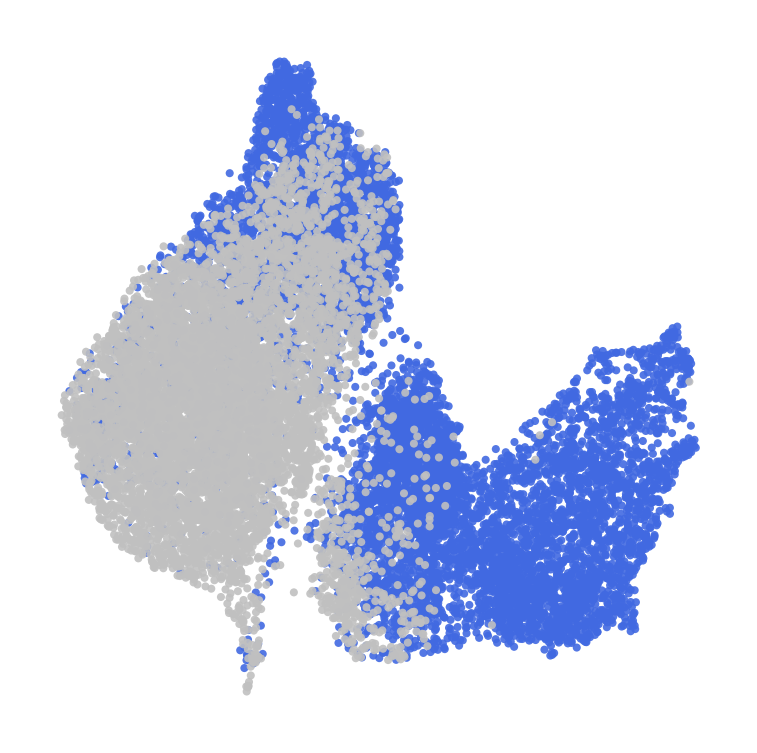

In [4]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3

dataset_colors = ["royalblue", "silver"]

sc.pl.umap(
    adata,
    color='dataset',
    size=15,
    # add_outline=True,
    # outline_color=('k', 'k'),
    frameon=False, 
    alpha=0.9,
    title="",
    palette=dataset_colors,
    legend_loc='none',
)

N cells per dataset post-filtering:


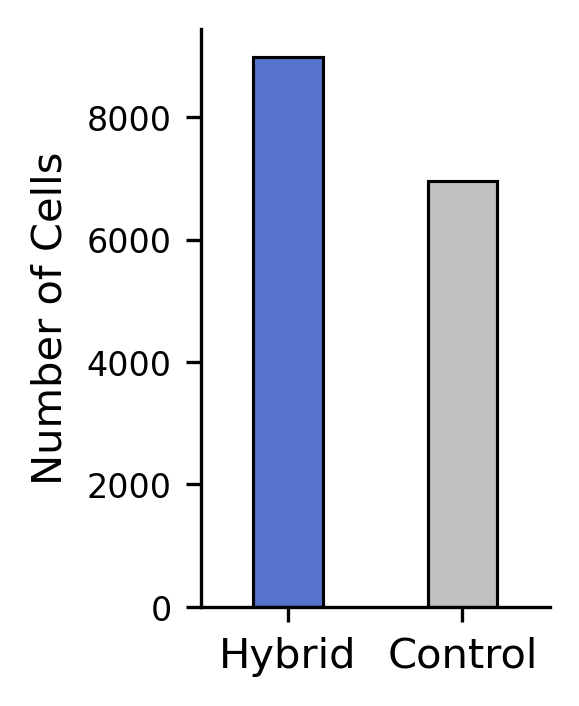

In [4]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 1.5, 2.5
fig, axs = plt.subplots()

# dataset_colors = ["royalblue", "silver"]
adata.uns['dataset_colors'] = ["royalblue", "silver"]

print("N cells per dataset post-filtering:")

sns.countplot(data=adata.obs,
            x='dataset',
            hue='dataset',
            width=0.4,
            ec='k',
            linewidth=0.75,
            palette=dataset_colors,
           )

plt.ylabel("Number of Cells")
plt.xlabel("")

plt.yticks(fontsize=8)

sns.despine()
plt.show()

In [19]:
gene_counts = {}

adata.X = adata.layers['raw_counts'].copy()

grouping_col = 'dataset'

for ds, idx in adata.obs.groupby(grouping_col, observed=True).indices.items():
    # subset of cells per dataset
    X_sub = adata[idx, :].X
    
    # count how many genes have at least one nonzero value
    detected = np.array((X_sub > 0).sum(axis=0)).ravel() > 0
    n_genes_detected = detected.sum()
    
    gene_counts[ds] = n_genes_detected

# Make a nice table
gene_counts_df = pd.DataFrame.from_dict(gene_counts, orient='index', columns=['Genes detected'])
# gene_counts_df = gene_counts_df.reset_index(names=grouping_col)
gene_counts_df

Genes detected
Hybrid            24725
Control           22423

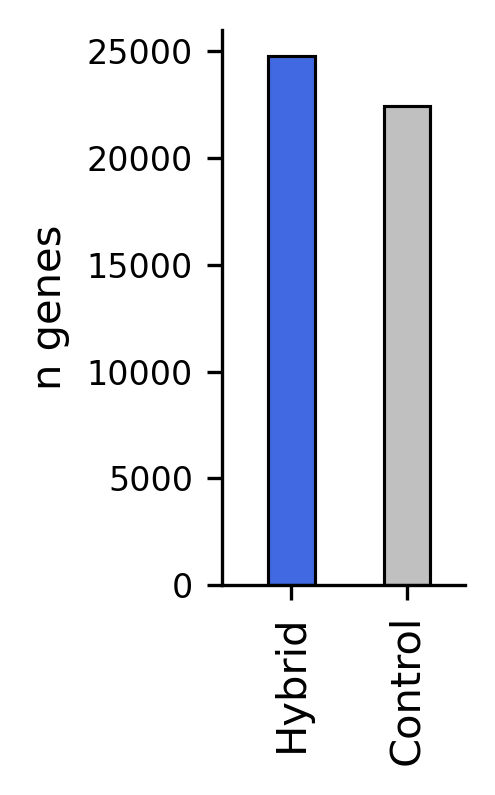

In [30]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 1.75, 2.75
fig, ax = plt.subplots()

ax.bar(
    x=gene_counts_df.index,
    height=gene_counts_df['Genes detected'],
    width=0.4,
    color=dataset_colors,
    edgecolor='k',
    linewidth=0.75,
)

plt.xticks(rotation=90)

ax.set_xticks([0, 1])
ax.set_xticklabels(['Hybrid', 'Control'])
ax.set_ylabel("n genes")
ax.set_xlim(-0.6, 1.5)
plt.yticks(fontsize=8)
# ax.set_ylim(0, 26000)

sns.despine()
plt.tight_layout()
plt.show()

# Conditions

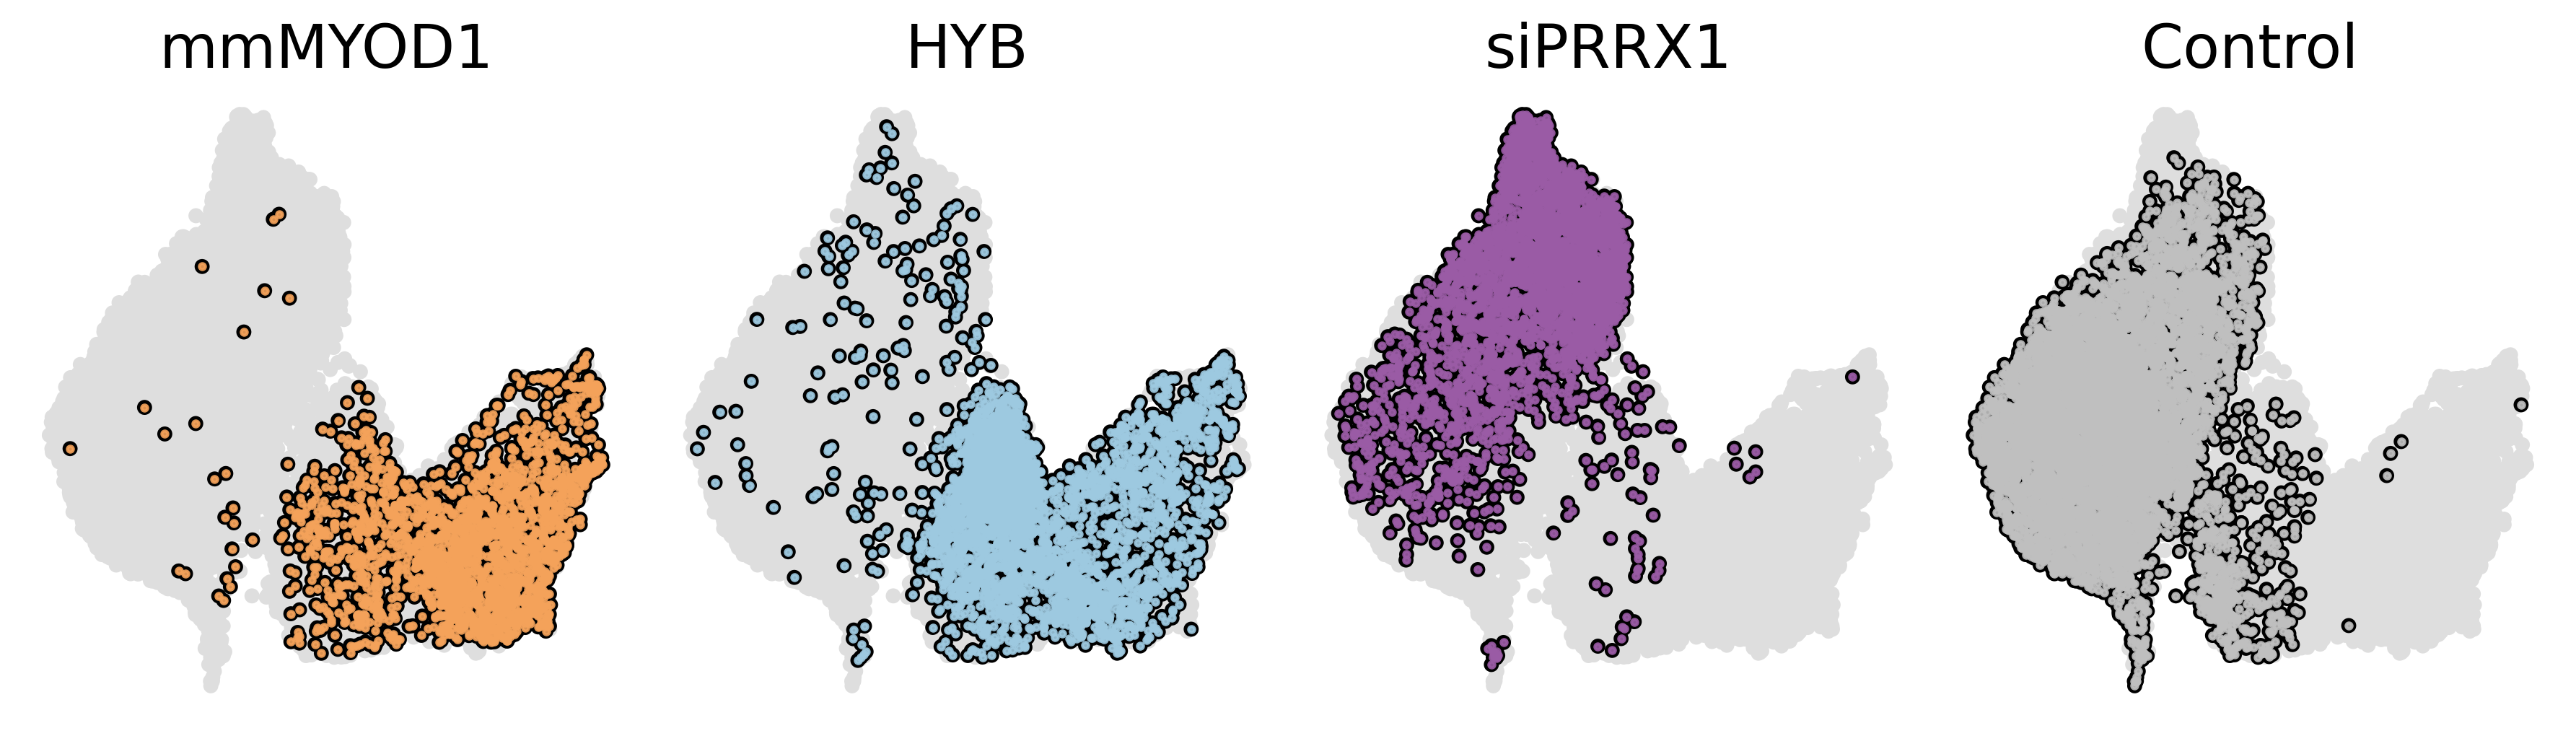

In [52]:
adata.obs['UMAP_1'] = adata.obsm['X_umap'][:, 0] 
adata.obs['UMAP_2'] = adata.obsm['X_umap'][:, 1]

predictions = ['mmMYOD1', 'HYB', 'siPRRX1', 'Control']

# titles = ['MYOD1$^+$', r'MYOD1$^+$PRRX1$^{\mathrm{KD}}$', 'PRRX1$^{KD}$', 'Control']
# titles = ['+MYOD1', r'PRRX1$^{\mathrm{KD}}$+MYOD1', r'PRRX1$^{\mathrm{KD}}$', 'Control']

ncols = 4
nrows = int(np.ceil(len(predictions) / ncols))

plt.rcParams['figure.figsize'] = 12, 3.5
plt.rcParams['figure.dpi'] = 300

fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
axes = axes.flatten()

colors = ["#F5A35B", "#9ECAE1", "#9B5CA6", "silver"]

for i, pred in enumerate(predictions):
    ax = axes[i]

    pred_indices = adata.obs['condition'] == pred

    # Plot background UMAP in grey
    sns.scatterplot(
        data=adata.obs,
        x='UMAP_1',
        y='UMAP_2',
        ec='none',
        s=25,
        color='#DEDEDE',
        ax=ax,
    )

    # Plot only the cells with the current prediction
    ax.scatter(
        adata.obs.loc[pred_indices, 'UMAP_1'],
        adata.obs.loc[pred_indices, 'UMAP_2'],
        c='black',
        s=25,
        alpha=1,
        edgecolors='none',
        linewidths=0,
    )

    
    ax.scatter(
        adata.obs.loc[pred_indices, 'UMAP_1'],
        adata.obs.loc[pred_indices, 'UMAP_2'],
        c=colors[i],
        s=4,
        label=pred,
        alpha=0.9,
    )
    
    ax.set_title(predictions[i], fontsize=20)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis(False)

# Remove any extra empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [6]:
adata.obs['pooled_condition'].value_counts(sort=False)

pooled_condition
Control            6960
mmMYOD1            2109
siPRRX1            3430
siPRRX1/mmMYOD1    3451
Name: count, dtype: int64

In [51]:
colors = [
    'silver', # (control)
    '#F5A35B', # orange (mmMYOD1)
    '#9B5CA6', # purple (siPRRX1)
    '#9ECAE1', # blue (HYB)
]

adata.uns['pooled_condition_colors'] = colors

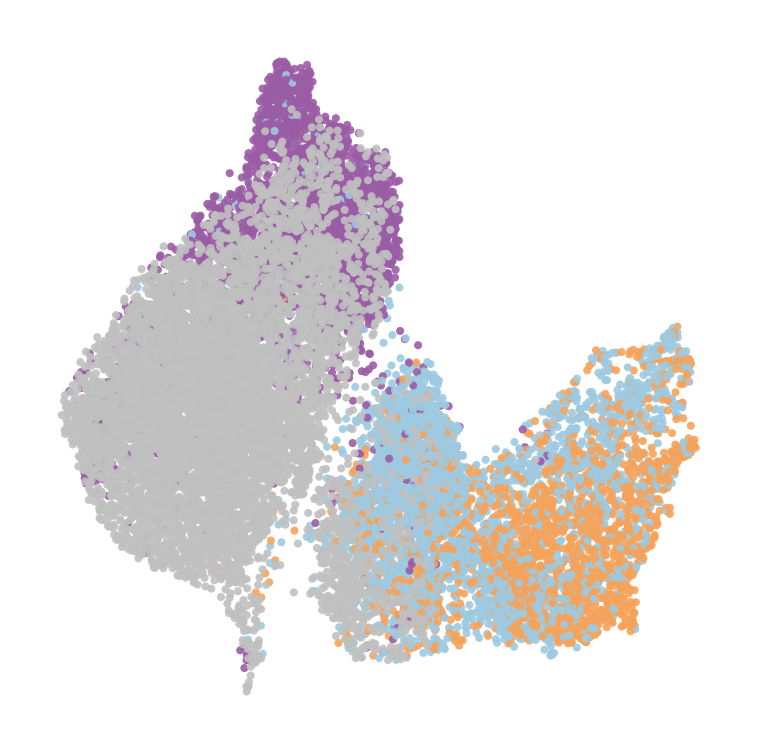

In [52]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3

sc.pl.umap(
    adata,
    color='pooled_condition',
    size=15,
    # add_outline=True,
    # outline_color=('k', 'k'),
    frameon=False, 
    alpha=0.9,
    title="",
    # palette=dataset_colors,
    legend_loc='none',
)

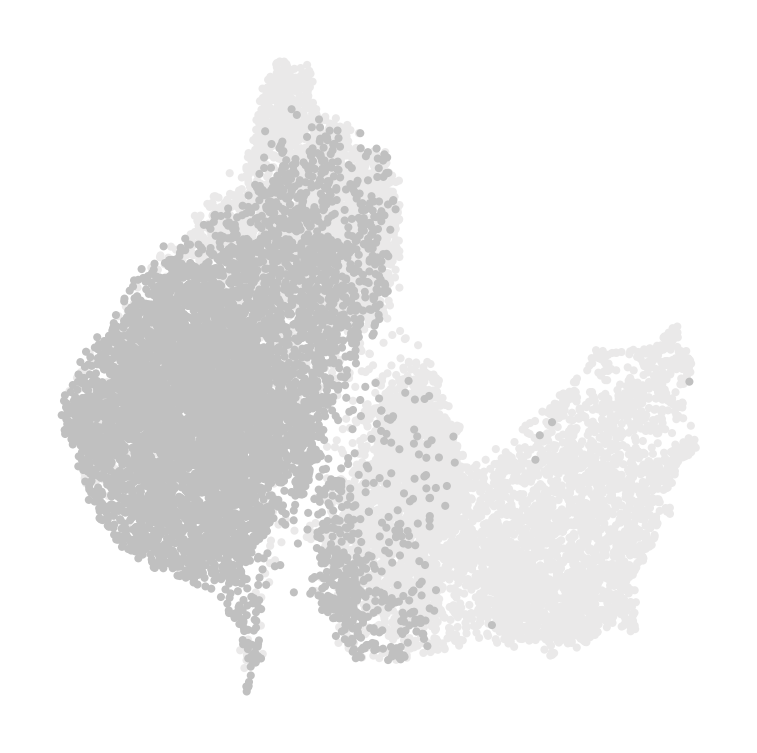

In [14]:
mask_prrx = adata.obs['pooled_condition'] == 'siPRRX1'
mask_myod = adata.obs['pooled_condition'] == 'mmMYOD1'
mask_hyb = adata.obs['pooled_condition'] == 'siPRRX1/mmMYOD1'
mask_ctrl = adata.obs['pooled_condition'] == 'Control'

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3

sc.pl.umap(
    adata,
    color='pooled_condition',
    mask_obs=mask_ctrl,
    size=15,
    frameon=False,
    alpha=1,
    na_color='#EAE9E9',
    title='',
    legend_loc='none',
    # legend_loc='on data',
    # na_in_legend=False,
    # legend_fontoutline=2,
    # legend_fontsize='medium',
)

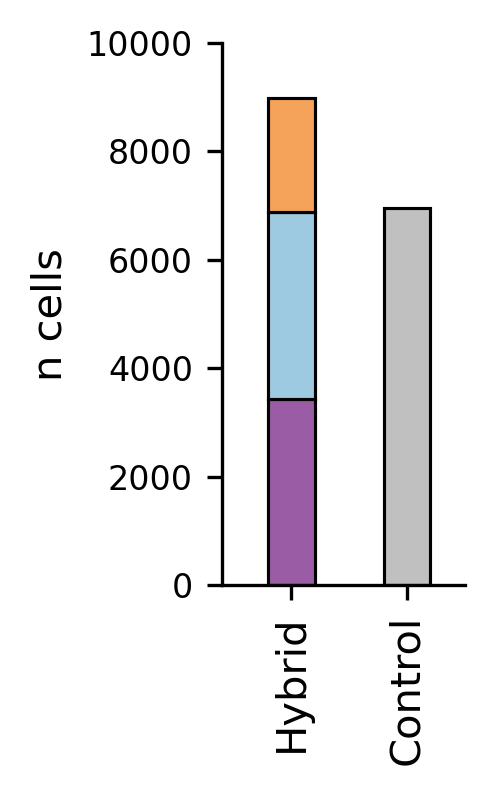

In [273]:
value_counts = adata.obs['pooled_condition'].value_counts()
value_counts = value_counts.rename('Cells')
value_counts = pd.DataFrame(value_counts).T

desired_order = ['siPRRX1', 'siPRRX1/mmMYOD1', 'mmMYOD1', 'Control']  
value_counts = value_counts.reindex(columns=desired_order)

group1_labels = ['siPRRX1', 'siPRRX1/mmMYOD1', 'mmMYOD1']
group2_label = 'Control'

# Extract counts
group1_counts = value_counts[group1_labels].iloc[0].values
group2_count = value_counts[group2_label].iloc[0]

# Calculate cumulative positions for stacking in group 1
cumulative = np.cumsum(np.insert(group1_counts, 0, 0))[:-1]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 1.75, 2.75 #6, 1.15
fig, ax = plt.subplots()


colors = [
    '#9B5CA6', # purple (siPRRX1)
    '#9ECAE1', # blue (HYB)
    '#F5A35B', # orange (mmMYOD1)
    'silver', # (control)
]

width = 0.4

# Plot stacked bar for group 1
for i in range(len(group1_labels)):
    ax.bar(
        x=0,
        height=group1_counts[i],
        bottom=cumulative[i],
        color=colors[i],  
        label=group1_labels[i],
        edgecolor='k',
        linewidth=0.75,
        width=width,
    )

# Plot single bar for Control
ax.bar(
    x=1,
    height=group2_count,
    color=colors[-1],  # Assuming the last color is for Control
    label=group2_label,
    edgecolor='k',
    linewidth=0.75,
    width=width,
)

# Formatting
ax.set_xticks([0, 1])
ax.set_xticklabels(['Hybrid', 'Control'])
ax.set_ylabel("n cells")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(-0.6, 1.5)
plt.yticks(fontsize=8)
ax.set_ylim(0, 10000)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

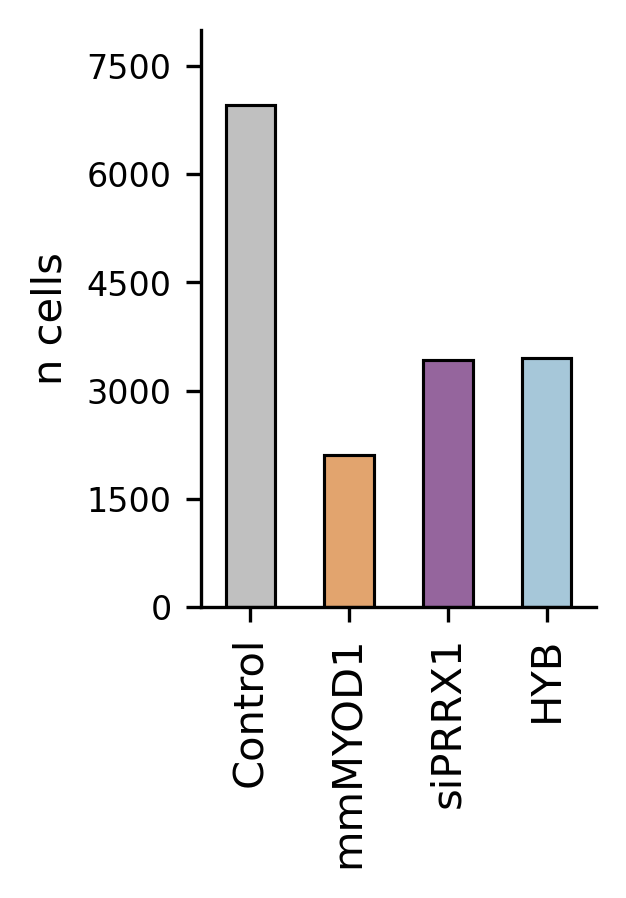

In [266]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 1.7, 2.5
fig, axs = plt.subplots()

color_map = {
    'Control': 'silver',
    'mmMYOD1': '#F5A35B',
    'HYB': '#9ECAE1',
    'siPRRX1': '#9B5CA6',
}

sns.countplot(data=adata.obs,
            x='condition',
            hue='condition',
            width=0.5,
            ec='k',
            linewidth=0.75,
            palette=color_map,
           )

plt.ylabel("n cells")
plt.xlabel("")

plt.yticks(fontsize=8)
plt.xticks(rotation=90)

plt.ylim([0, 8000])

axs.yaxis.set_major_locator(mticker.MaxNLocator(nbins=7))

sns.despine()
plt.show()

# QC metrics

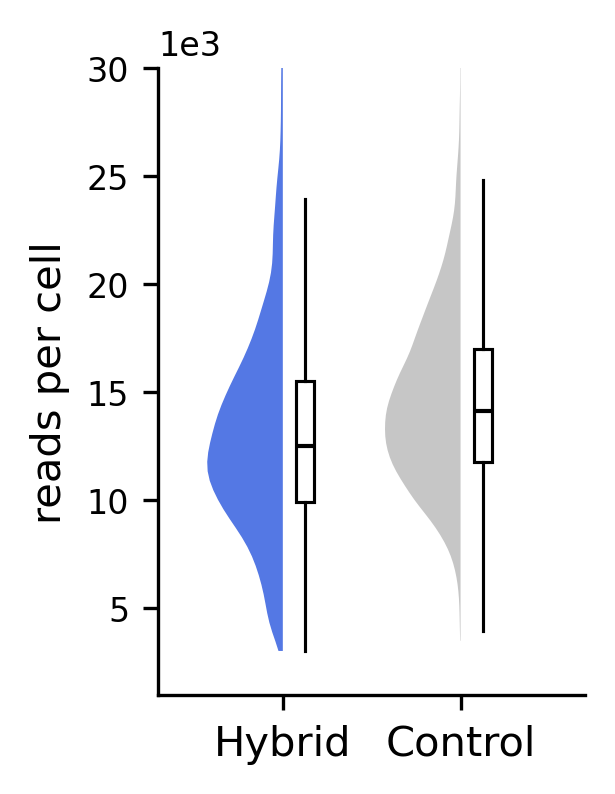

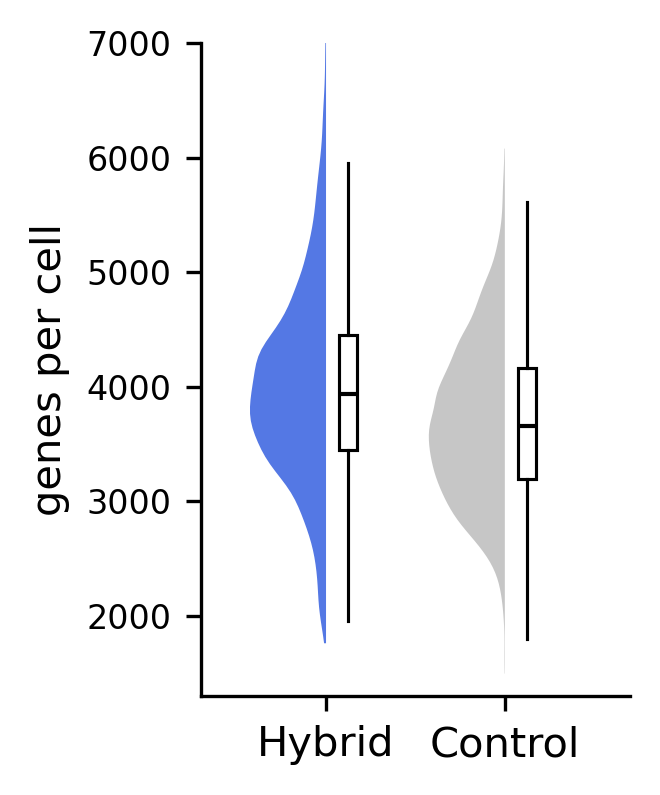

In [240]:
metrics = ['total_reads', 'total_genes']
dpi = 300

for metric in metrics:
    plt.rcParams['figure.dpi'] = dpi
    
    if metric == 'total_reads':
        plt.rcParams['figure.figsize'] = (2.15, 2.75)
    elif metric == 'total_genes':
        plt.rcParams['figure.figsize'] = (2.3, 2.75)

    fig, ax = plt.subplots()

    datasets = adata.obs["dataset"].unique()

    violin_width = 0.85
    box_width = 0.1
    offset = violin_width/6 - box_width/6

    for i, dataset in enumerate(datasets):
        vals = adata.obs.loc[adata.obs["dataset"] == dataset, metric]

        # --- Half violin (left of tick) ---
        parts = ax.violinplot(
            vals,
            positions=[i],         
            widths=0.85,
            showmeans=False,
            showmedians=False,
            showextrema=False
        )
        for pc in parts['bodies']:
            verts = pc.get_paths()[0].vertices
            mean_x = np.mean(verts[:, 0])
            verts[:, 0] = np.minimum(verts[:, 0], mean_x)  # keep left half
            pc.set_facecolor(dataset_colors[i])
            pc.set_alpha(0.9)

        # --- Boxplot (slightly right of tick) ---
        box = ax.boxplot(
            vals,
            positions=[i + offset],   # offset right
            widths=0.1,
            patch_artist=True,
            showcaps=False,
            showfliers=False,
            whiskerprops={"linewidth": 0.75},
            medianprops={"color": "black", "linewidth": 1},
            boxprops={'linewidth': 0.75},
        )
        for patch in box['boxes']:
            patch.set_facecolor('white')
            patch.set_edgecolor("black")


    ax.set_xlim(-0.7, len(datasets) - 0.3)

    ax.set_xticks(range(len(datasets)))
    ax.set_xticklabels(datasets)
    ax.set_xlabel("")
    
    if metric == 'total_reads':
        ax.set_ylabel("reads per cell")
    elif metric == 'total_genes':
        ax.set_ylabel("genes per cell")
        
    plt.yticks(fontsize=8)
    
    if metric == 'total_reads':
        plt.ylim([1000, 30000])
        ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x/1000)}"))
        ax.yaxis.set_major_locator(mticker.MaxNLocator(nbins=6))
        ax.annotate("1e3", xy=(0, 1.01), xycoords=("axes fraction", "axes fraction"),
                    ha="left", va="bottom", fontsize=8)
        
    if metric == 'total_genes':
        plt.ylim([1300, 7000])

    sns.despine()
    plt.tight_layout()
    plt.show()

In [ ]:
# ### KDE plot

# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 3.5, 2

# sns.kdeplot(
#     data=adata.obs,
#     x='total_reads',
#     hue='dataset',
#     fill=True,
#     alpha=0.65,
#     linewidth=0,
#     palette=dataset_colors,
#     legend=False,
# )


# plt.xlim([0, 40000])
# plt.xlabel("reads per cell")

# sns.despine()
# plt.tight_layout()
# plt.show()

In [ ]:
# ### Boxplot 

# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 2.25, 2.5

# sns.boxplot(
#     data=adata.obs,
#     x='dataset',
#     y='total_reads',
#     hue='dataset',
#     palette=dataset_colors,
#     showfliers=False,
#     linecolor='k',
#     width=0.5,
#     showcaps=False,
# )

# plt.ylabel("reads per cell")
# plt.xlabel("")


# sns.despine()
# plt.tight_layout()
# plt.show()

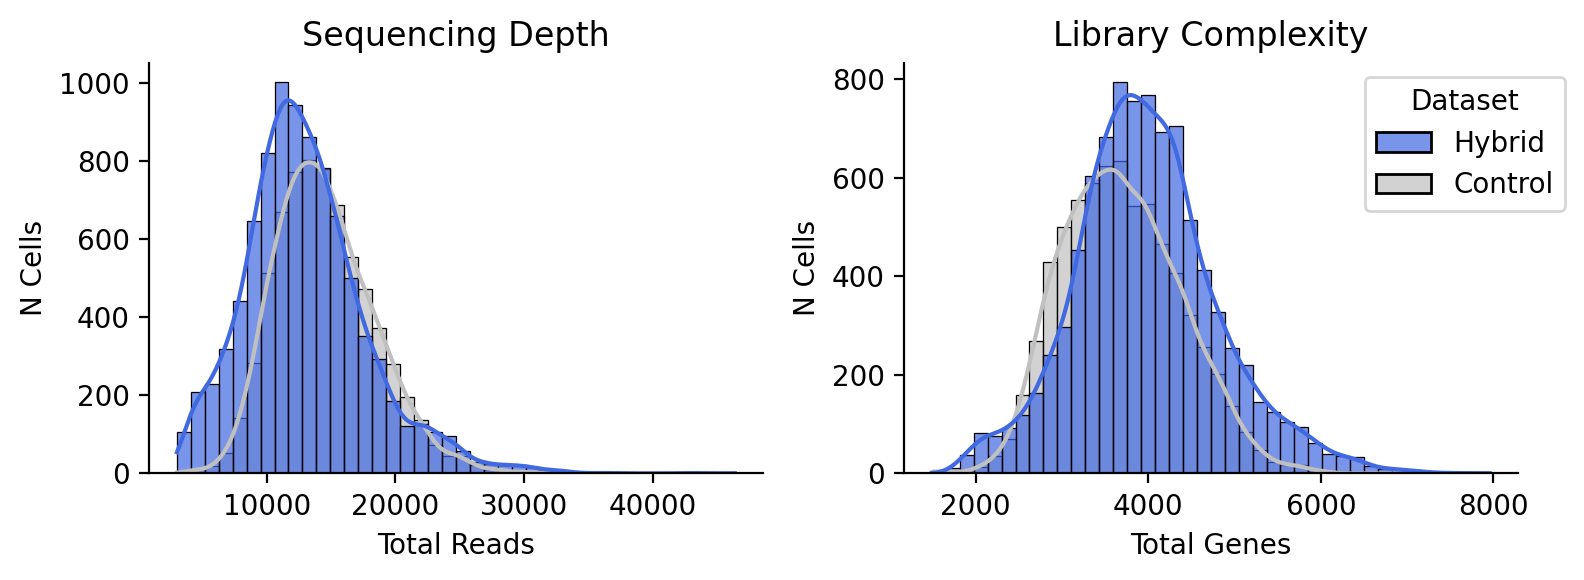

In [223]:
### Histograms

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 3
fig, axs = plt.subplots(1, 2)

sns.histplot(data=adata.obs, x=adata.obs['total_reads'], hue=adata.obs['dataset'],
             palette=dataset_colors, bins=40, kde=True, ax=axs[0], legend=False, alpha=0.7)

axs[0].set_ylabel("N Cells")
axs[0].set_xlabel("Total Reads")
axs[0].set_title("Sequencing Depth")


sns.histplot(data=adata.obs, x=adata.obs['total_genes'], hue=adata.obs['dataset'],
             palette=dataset_colors, bins=40, kde=True, ax=axs[1], alpha=0.7)

axs[1].set_ylabel("N Cells")
axs[1].set_xlabel("Total Genes")
axs[1].set_title("Library Complexity")

sns.move_legend(plt.gca(), loc='upper right', title='Dataset', bbox_to_anchor=(1.1, 1))

sns.despine()
plt.tight_layout()
plt.show()

# Cell cycle phase

In [5]:
phase_group_map = {
    "G1": "G1/S",
    "S": "G1/S",
    "G2M": "G2/M"
}

adata.obs["condition_by_phase_group"] = (
    adata.obs["pooled_condition"].astype(str) + "_" +
    adata.obs["phase"].map(phase_group_map)
)

# Make categorical and optionally order
conditions = ["Control", "mmMYOD1", "siPRRX1", "siPRRX1/mmMYOD1"]
phase_groups = ["G1/S", "G2/M"]
ordered_categories = [f"{cond}_{ph}" for ph in phase_groups for cond in conditions]

adata.obs["condition_by_phase_group"] = pd.Categorical(
    adata.obs["condition_by_phase_group"],
    categories=ordered_categories,
    ordered=True
)

adata.obs["condition_by_phase_group"].value_counts(sort=False)

condition_by_phase_group
Control_G1/S            3770
mmMYOD1_G1/S            1733
siPRRX1_G1/S            1936
siPRRX1/mmMYOD1_G1/S    2415
Control_G2/M            3190
mmMYOD1_G2/M             376
siPRRX1_G2/M            1494
siPRRX1/mmMYOD1_G2/M    1036
Name: count, dtype: int64

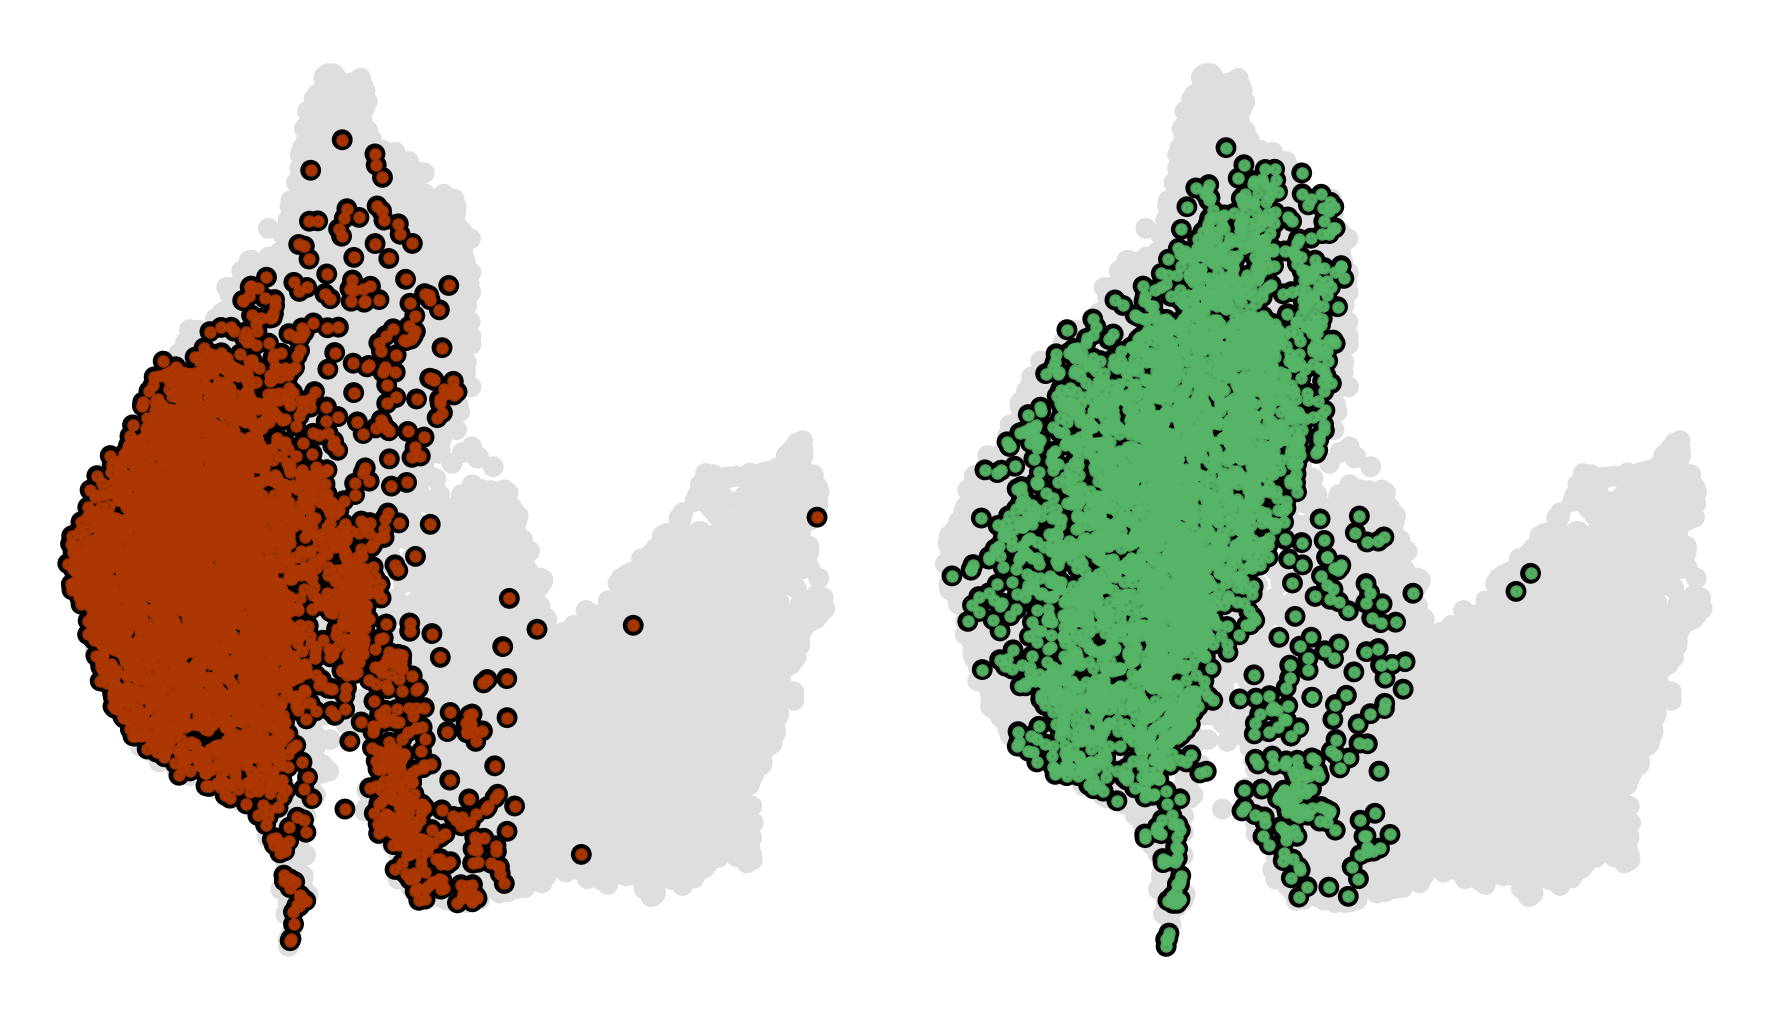

In [7]:
plt.rcParams['figure.figsize'] = 6, 3.5
plt.rcParams['figure.dpi'] = 300

fig, axes = plt.subplots(nrows=1, ncols=2)
axes = axes.flatten()

# colors = ["#F5A35B", "#9ECAE1", "#9B5CA6", "silver"]

colors = ['#ad3803', '#56b567']

group = 'Control'

group_phases = [f'{group}_G1/S', f'{group}_G2/M']

for i, phase in enumerate(group_phases):
    ax = axes[i]

    phase_indices = adata.obs['condition_by_phase_group'] == phase

    # Plot background UMAP in grey
    sns.scatterplot(
        data=adata.obs,
        x='UMAP_1',
        y='UMAP_2',
        ec='none',
        s=25,
        color='#DEDEDE',
        ax=ax,
    )

    # Plot only the cells with the current prediction
    ax.scatter(
        adata.obs.loc[phase_indices, 'UMAP_1'],
        adata.obs.loc[phase_indices, 'UMAP_2'],
        c='black',
        s=25,
        alpha=1,
        edgecolors='none',
        linewidths=0,
    )

    
    ax.scatter(
        adata.obs.loc[phase_indices, 'UMAP_1'],
        adata.obs.loc[phase_indices, 'UMAP_2'],
        c=colors[i],
        s=4,
        label=phase,
        alpha=0.9,
    )
    
    ax.set_title("")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis(False)

# Remove any extra empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [27]:
adata.obs["condition_by_phase"] = (
    adata.obs["pooled_condition"].astype(str) + "_" + adata.obs["phase"].astype(str)
)

conditions = ["Control", "mmMYOD1", "siPRRX1", "siPRRX1/mmMYOD1"]
phases = ["G1", "S", "G2M"]

ordered_categories = [f"{cond}_{ph}" for ph in phases for cond in conditions]

# Apply categorical with ordering
adata.obs["condition_by_phase"] = pd.Categorical(
    adata.obs["condition_by_phase"],
    categories=ordered_categories,
    ordered=True
)

# Now value_counts will respect this order if you use sort=False
adata.obs["condition_by_phase"].value_counts(sort=False)

condition_by_phase
Control_G1             3551
mmMYOD1_G1             1422
siPRRX1_G1             1409
siPRRX1/mmMYOD1_G1     1803
Control_S               219
mmMYOD1_S               311
siPRRX1_S               527
siPRRX1/mmMYOD1_S       612
Control_G2M            3190
mmMYOD1_G2M             376
siPRRX1_G2M            1494
siPRRX1/mmMYOD1_G2M    1036
Name: count, dtype: int64

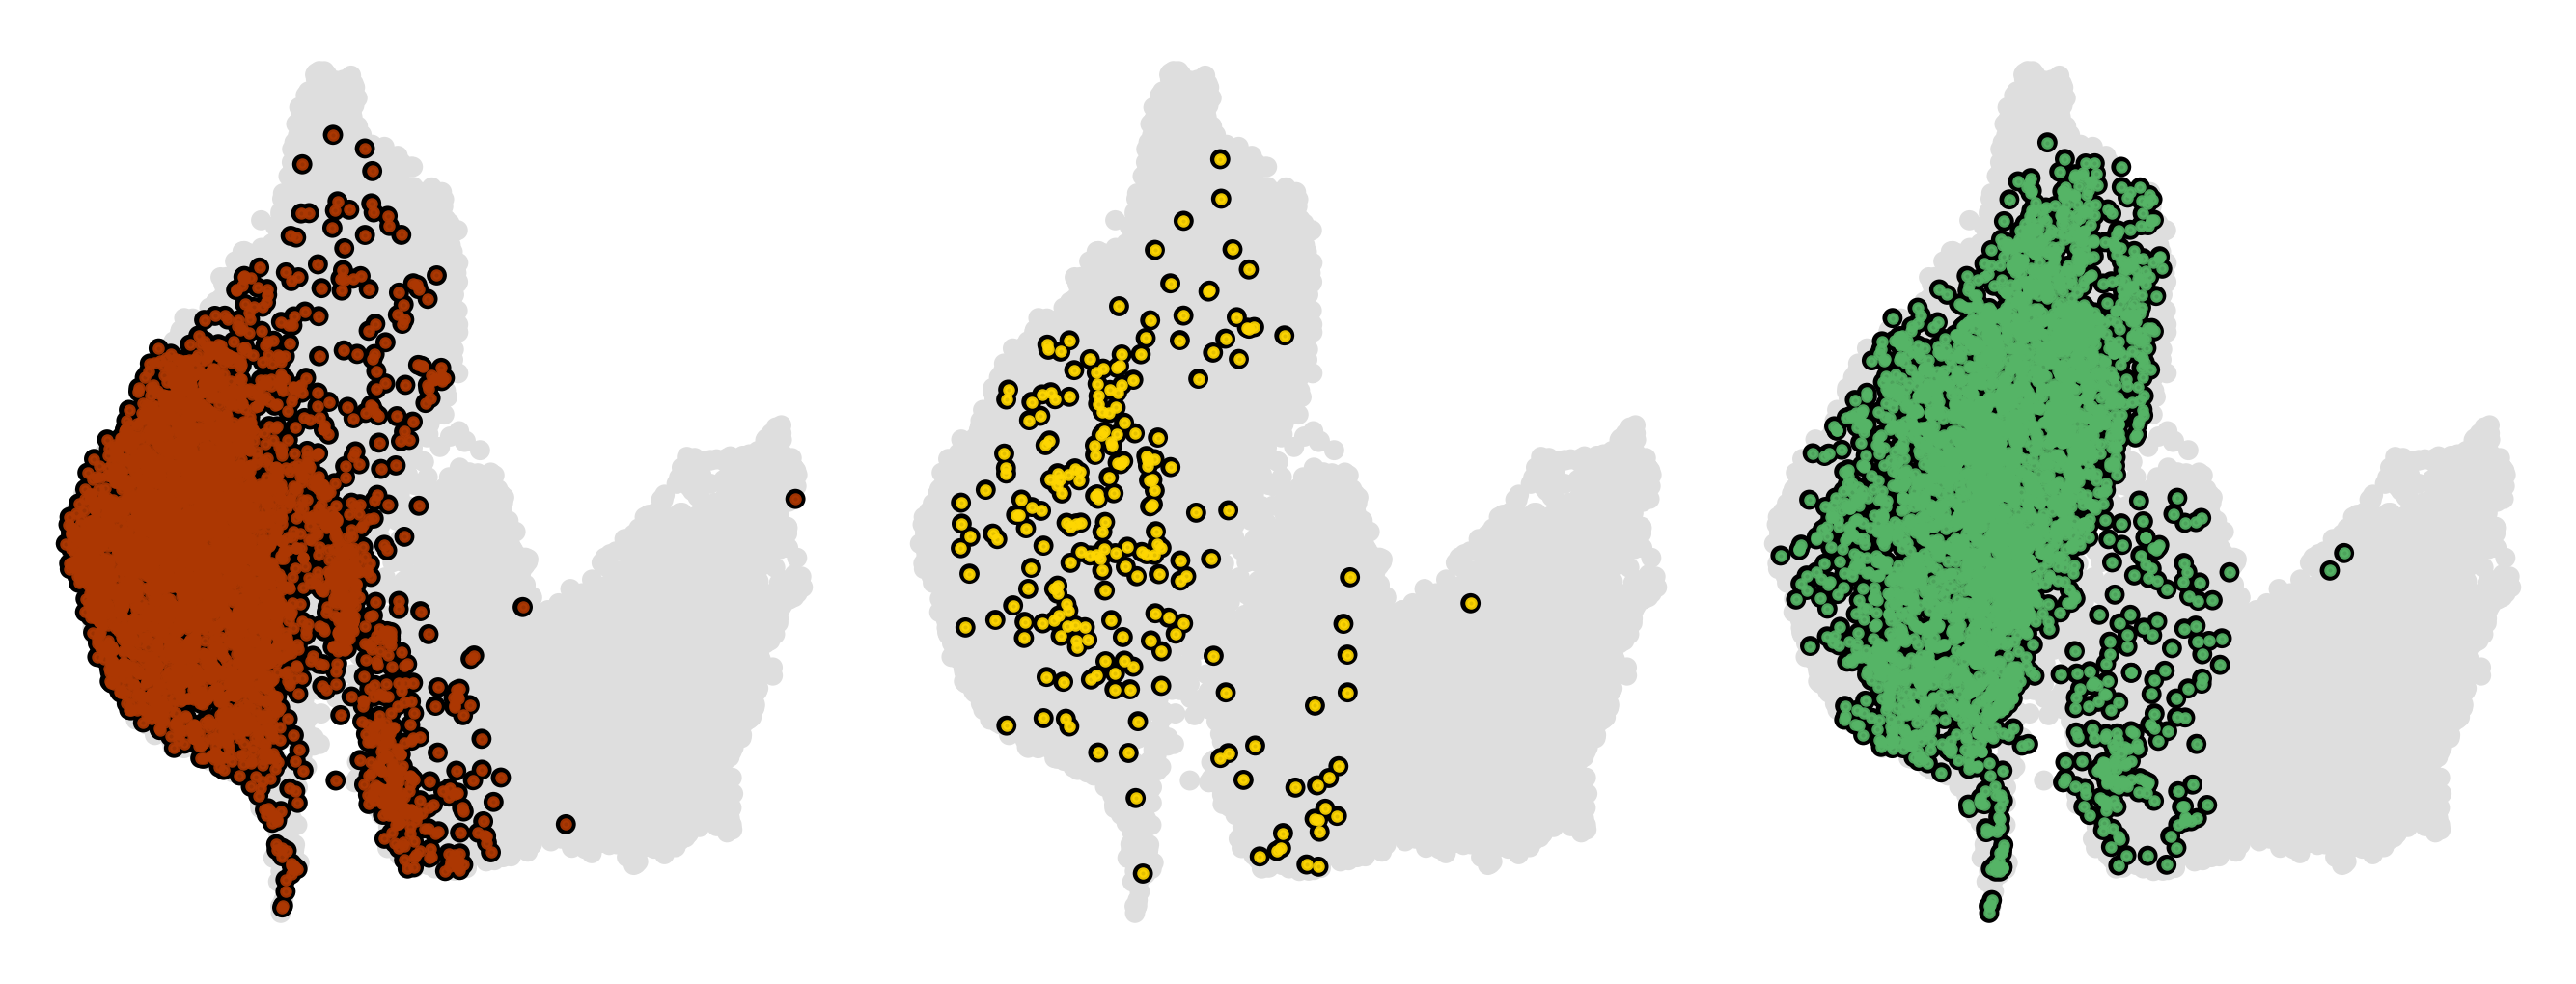

In [31]:
plt.rcParams['figure.figsize'] = 9, 3.5
plt.rcParams['figure.dpi'] = 300

fig, axes = plt.subplots(nrows=1, ncols=3)
axes = axes.flatten()


colors = ['#ad3803', 'gold', '#56b567']

group = 'Control'

group_phases = [f'{group}_G1', f'{group}_S', f'{group}_G2M']

for i, phase in enumerate(group_phases):
    ax = axes[i]

    phase_indices = adata.obs['condition_by_phase'] == phase

    # Plot background UMAP in grey
    sns.scatterplot(
        data=adata.obs,
        x='UMAP_1',
        y='UMAP_2',
        ec='none',
        s=25,
        color='#DEDEDE',
        ax=ax,
    )

    # Plot only the cells with the current prediction
    ax.scatter(
        adata.obs.loc[phase_indices, 'UMAP_1'],
        adata.obs.loc[phase_indices, 'UMAP_2'],
        c='black',
        s=25,
        alpha=1,
        edgecolors='none',
        linewidths=0,
    )

    
    ax.scatter(
        adata.obs.loc[phase_indices, 'UMAP_1'],
        adata.obs.loc[phase_indices, 'UMAP_2'],
        c=colors[i],
        s=4,
        label=phase,
        alpha=0.9,
    )
    
    ax.set_title("")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis(False)

# Remove any extra empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Violins

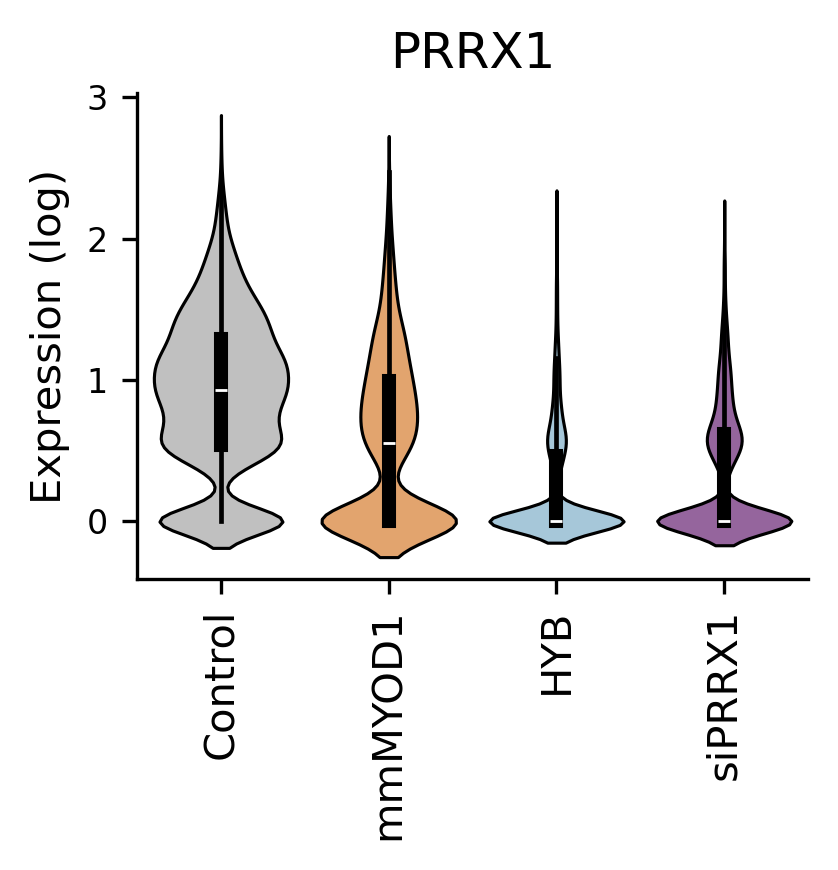

In [54]:
gene_to_plot = 'PRRX1'

adata.X = adata.layers["log_norm"].copy()

gene_exp = adata[:, gene_to_plot].X.toarray().flatten()
groups = adata.obs['condition']

data = pd.DataFrame({'expression': gene_exp, 'group': groups})

color_map = {
    'Control': 'silver',
    'mmMYOD1': '#F5A35B',
    'HYB': '#9ECAE1',
    'siPRRX1': '#9B5CA6',
}

plot_order = ['Control', 'mmMYOD1', 'HYB', 'siPRRX1']


plt.rcParams['figure.figsize'] = 3, 3
plt.rcParams['figure.dpi'] = 300

sns.violinplot(
    data=data,
    x='group',
    y='expression',
    hue='group',
    order=plot_order,
    hue_order=plot_order,
    linewidth=0.75,
    linecolor='k',
    palette=color_map,
    legend=False,
)


plt.xlabel("")
# plt.xticks([])
plt.xticks(rotation=90)#, ha='right')#fontsize=7, rotation=90)
plt.yticks(fontsize=8)
plt.ylabel("Expression (log)")
plt.title(f"{gene_to_plot}")

sns.despine()
plt.tight_layout()
plt.show()

# Gene expression

In [41]:
adata.X = adata.layers["raw_counts"].copy()

gdata = sc.get.aggregate(
    adata, 
    by='pooled_condition',
    func='sum',
    axis=0,
)

print(gdata.shape)

gdata.X = gdata.layers['sum'].copy()

sc.pp.normalize_total(gdata, target_sum=1e4)
sc.pp.log1p(gdata)

gdata.layers['log_norm'] = gdata.X.copy()

(4, 25042)
normalizing counts per cell
    finished (0:00:00)


In [42]:
genes_of_interest = [
    # 'MYOD1', 'ACTN2', 'MEF2A', 'MEF2C', 'PAX3', 'SIX1', 'DOCK5', 'SHOX',
    # 'PRRX1', 'COL1A1', 'COL1A1', 'DCN', 'LUM', 'FAP', 'TIMP1', 'ELN', 'TWIST1', 'TWIST2',
    'MYOD1', 'MEF2A', 'MEF2C', 'MEF2D', 'PAX3', 'SIX1', 'ACTN2', 'MYOCD',
    'PRRX1', 'COL1A1', 'COL1A1', 'DCN', 'LUM', 'FAP', 'TIMP1', 'ELN', 'TWIST1', 'TWIST2',
    
]

cond_order = ['Control', 'siPRRX1', 'siPRRX1/mmMYOD1', 'mmMYOD1']

    
gdata = gdata[cond_order, genes_of_interest].copy()
print(gdata.shape)

df = gdata.to_df()

# compute gene-wise z-score
df_z = df.apply(scipy.stats.zscore, axis=0)

df_z.head()

(4, 18)


gene_name           MYOD1     MEF2A     MEF2C     MEF2D      PAX3      SIX1  \
Control         -0.962747 -1.593912 -1.149662 -0.725039 -1.369759 -0.389524   
siPRRX1         -0.962747  0.147614 -0.779888 -0.795533 -0.493295 -1.159788   
siPRRX1/mmMYOD1  0.580337  0.280562  1.287631 -0.157694  0.662328 -0.032492   
mmMYOD1          1.345156  1.165736  0.641918  1.678266  1.200726  1.581805   

gene_name           ACTN2     MYOCD     PRRX1    COL1A1    COL1A1       DCN  \
Control         -1.088576 -0.546157  1.398657  1.639647  1.639647  1.583514   
siPRRX1         -0.907302 -0.901387 -0.739997 -0.032644 -0.032644  0.076073   
siPRRX1/mmMYOD1  0.993417 -0.235790 -1.129095 -0.705366 -0.705366 -0.595717   
mmMYOD1          1.002461  1.683335  0.470435 -0.901637 -0.901637 -1.063869   

gene_name             LUM       FAP     TIMP1       ELN    TWIST1    TWIST2  
Control          1.535941  1.686013  1.695212  1.716859  0.903653 -1.030612  
siPRRX1          0.216763 -0.188252 -0.231755 -0.655667  0.996003  1.655979  
siPRRX1/mmMYOD1 -0.706185 -0.737095 -0.702612 -0.702977 -0.509918 -0.308689  
mmMYOD1         -1.046519 -0.760665 -0.760844 -0.358215 -1.389738 -0.316678

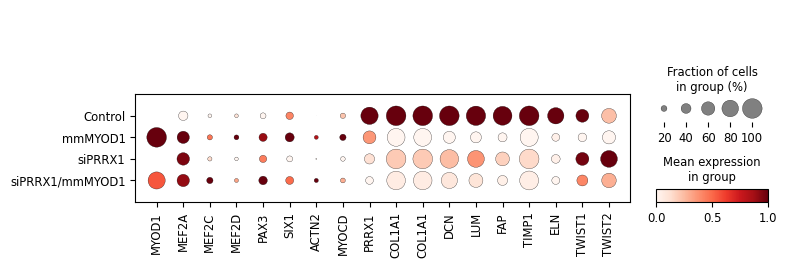

In [40]:
# genes_of_interest = [
#     'MYOD1', 'ACTN2', 'MEF2A', 'MEF2C', 'MEF2D', 'PAX3', 'PAX7', 'SIX1', 'MYOCD', 
#     'EP300', 'CREBBP', 'SMARCA4', 'BRG1', 'HDAC4', 'HDAC5', 'EZH2', 'SP1', 'TGFB1', 'SMAD3', 'KAT2B', 'TEAD4',
    
#     'PRRX1', 'COL1A1', 'COL1A1', 'DCN', 'LUM', 'FAP', 'TIMP1', 'ELN', 'TWIST1', 'TWIST2',
# ]

genes_of_interest = [
    # Myogenesis/skeletal muscle
    'MYOD1', 'MEF2A', 'MEF2C', 'MEF2D', 'PAX3', 'SIX1', 'ACTN2', 'MYOCD',
    # Important for myogenic reprogramming
    # 'EGR1', 'JUNB', 'FOS',  
    # Fibroblast
    'PRRX1', 'COL1A1', 'COL1A1', 'DCN', 'LUM', 'FAP', 'TIMP1', 'ELN', 'TWIST1', 'TWIST2',
]


genes_to_plot = [g for g in genes_of_interest if g in adata.var_names]

sc.pl.dotplot(
    adata,
    groupby='pooled_condition',
    var_names=genes_to_plot,
    standard_scale='var',
)

## Heatmap

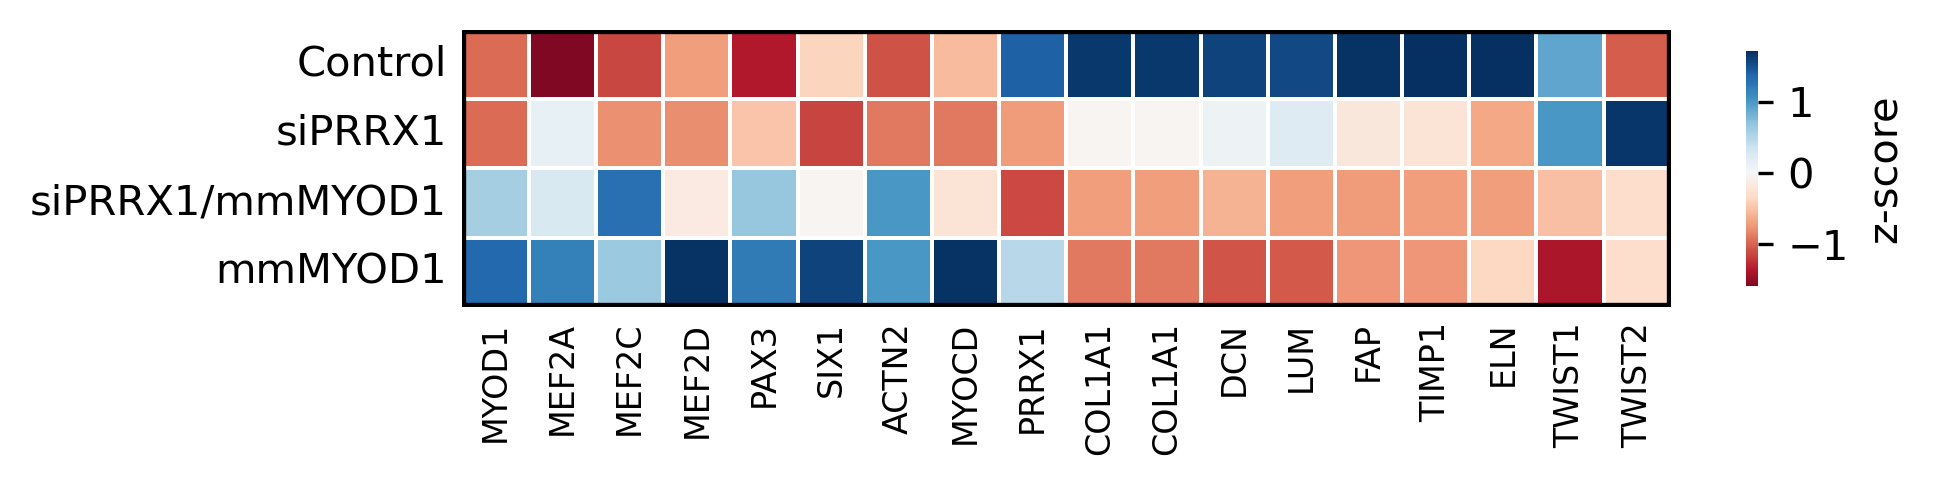

In [49]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6.5, 1.2

fig, ax = plt.subplots()

sns.heatmap(
    df_z,
    cmap='RdBu',
    center=0,
    lw=0.5,
    linecolor='white',
    cbar_kws={'label':'z-score', 'shrink': 0.85, 'pad': 0.05},
    ax=ax,
)

plt.xlabel("")
ax.tick_params(axis='both', bottom=False, left=False, pad=0.05)

n_rows, n_cols = df_z.shape
ax.set_xticks(np.arange(n_cols) + 0.5)
ax.set_xticklabels(df_z.columns, rotation=90, fontsize=8)


# Add black box around matrix
n_rows, n_cols = df_z.shape
rect = patches.Rectangle(
    (0, 0), n_cols, n_rows,
    linewidth=2, edgecolor='black', facecolor='none', zorder=10
)
ax.add_patch(rect)

plt.show()

## UMAP

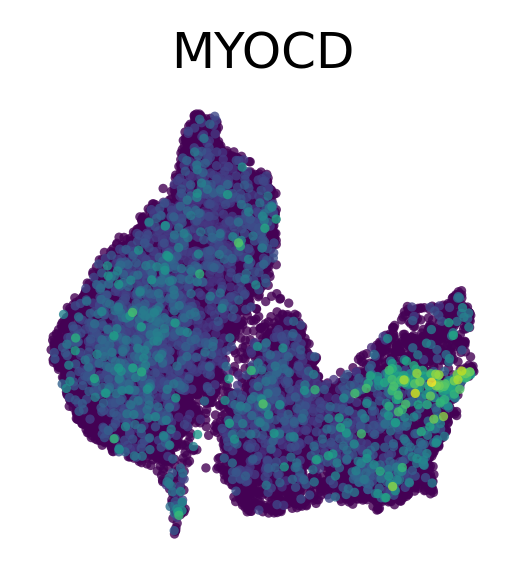

In [22]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 2, 2

genes = ['MYOD1', 'PRRX1']

sc.pl.umap(
    adata,
    color='MYOCD',
    ncols=1,
    size=20,
    # add_outline=True,
    # outline_color=('k', 'k'),
    frameon=False, 
    alpha=0.8,
    layer='log_norm',
    colorbar_loc=None,
    # hspace=0.25,
    # wspace=0.1, 
)

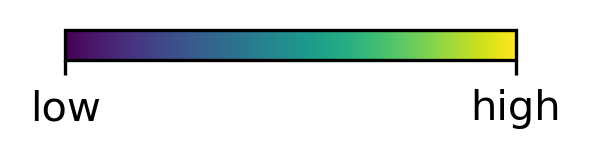

In [21]:
plt.rcParams['figure.dpi'] = 300
fig, ax = plt.subplots(figsize=(2.5, 1))

vmin = 0 
vmax = 1 

cbar = fig.colorbar(
    plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax)),
    cax=ax, orientation='horizontal'
)

ax.set_position([0.2, 0.1, 0.6, 0.1]) # [left, bottom, width, height] in figure coordinates

cbar.set_ticks([0, 1])
cbar.set_ticklabels(['low', 'high'])

# cbar.set_label("score", fontsize=11)
cbar.ax.tick_params(labelsize=10)
plt.show()

# qPCR results

In [68]:
df = pd.DataFrame({
    "Sample" : ['Control', r'PRRX1$^{\mathrm{KD}}$', r'PRRX1$^{\mathrm{KD}}$+MYOD1', '+MYOD1', 'siRNA nonsense'],
    "MYOD1" : [0, -1.08467, -9.75667, -9.88333, 0.07667],
    "PRRX1" : [0, 2.585, 1.99133, -0.482, -1.04867]
})
# ddCt
df.set_index('Sample', inplace=True)
print(f"ddCt: {df}\n")

df = df.apply(lambda x: -x)
print(f"-ddCt: {df}\n")

# 2^(-ddCt)
df = df.apply(lambda x: 2**(x))
print(f"2^-ddCt: {df}\n")

#log
df = df.apply(lambda x: np.log2(x))

df.reset_index(inplace=True)

df = df.melt(id_vars='Sample', var_name='Gene', value_name='log2fc')

df

ddCt:                                MYOD1    PRRX1
Sample                                       
Control                      0.00000  0.00000
PRRX1$^{\mathrm{KD}}$       -1.08467  2.58500
PRRX1$^{\mathrm{KD}}$+MYOD1 -9.75667  1.99133
+MYOD1                      -9.88333 -0.48200
siRNA nonsense               0.07667 -1.04867

-ddCt:                                MYOD1    PRRX1
Sample                                       
Control                     -0.00000 -0.00000
PRRX1$^{\mathrm{KD}}$        1.08467 -2.58500
PRRX1$^{\mathrm{KD}}$+MYOD1  9.75667 -1.99133
+MYOD1                       9.88333  0.48200
siRNA nonsense              -0.07667  1.04867

2^-ddCt:                                   MYOD1     PRRX1
Sample                                           
Control                        1.000000  1.000000
PRRX1$^{\mathrm{KD}}$          2.120890  0.166662
PRRX1$^{\mathrm{KD}}$+MYOD1  865.068161  0.251507
+MYOD1                       944.449600  1.396679
siRNA nonsense                 0

Sample   Gene   log2fc
0                      Control  MYOD1  0.00000
1        PRRX1$^{\mathrm{KD}}$  MYOD1  1.08467
2  PRRX1$^{\mathrm{KD}}$+MYOD1  MYOD1  9.75667
3                       +MYOD1  MYOD1  9.88333
4               siRNA nonsense  MYOD1 -0.07667
5                      Control  PRRX1  0.00000
6        PRRX1$^{\mathrm{KD}}$  PRRX1 -2.58500
7  PRRX1$^{\mathrm{KD}}$+MYOD1  PRRX1 -1.99133
8                       +MYOD1  PRRX1  0.48200
9               siRNA nonsense  PRRX1  1.04867

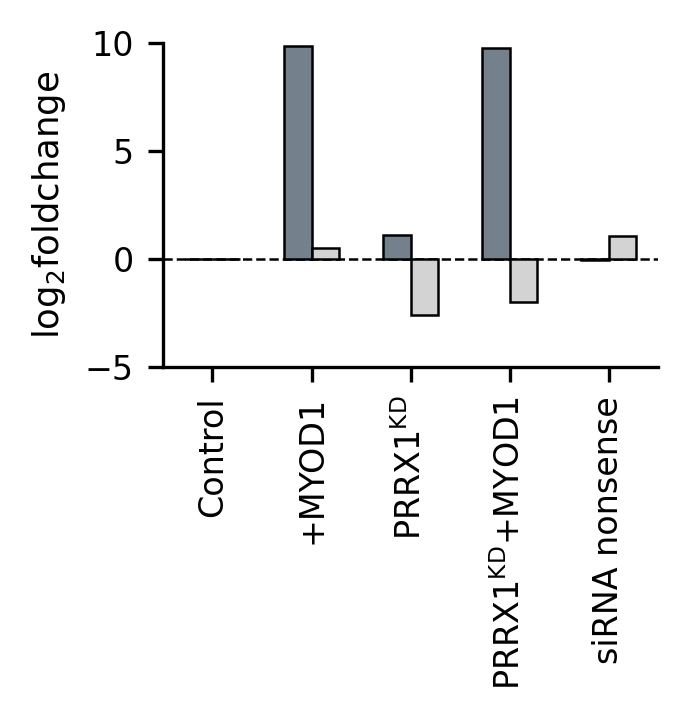

In [83]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 2.5, 2.5

# palette = ['lightsalmon', 'lightslategray']
palette = ['slategrey', 'lightgray']

order = ['Control', '+MYOD1', r'PRRX1$^{\mathrm{KD}}$', r'PRRX1$^{\mathrm{KD}}$+MYOD1', 'siRNA nonsense']

sns.barplot(
    data=df,
    x='Sample',
    y='log2fc',
    order=order,
    hue='Gene',
    width=0.55,
    ec='k',
    palette=palette,
    linewidth=0.6,
    zorder=1,
    legend=False,
)

# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.axhline(0, color='black', linestyle='--', linewidth=0.6, zorder=0)

plt.xticks(fontsize=8, rotation=90, ha='center', va='top')
plt.yticks(fontsize=8)

plt.xlabel('')
plt.ylabel('log$_2$foldchange', fontsize=8.5)
plt.ylim([-5, 10])

sns.despine()
plt.tight_layout()
plt.show()

# qPCR (updated)
SYBR green RT-qPCR performed 09/23/2025

In [4]:
def subset_qpcr_data(df, gene, conditions):
    """
    Subset qPCR results dataframe for a specific gene and set of conditions.

    Parameters:
        df (pd.DataFrame): Original qPCR results table with columns:
            'condition', 'sample_id', 'bio_replicate', 'tech_replicate', gene columns
        gene (str): The gene to analyze (must match column name in df)
        conditions (list of str): Conditions to include

    Returns:
        pd.DataFrame: Subset of the dataframe for analysis
    """
    # Check gene exists
    if gene not in df.columns:
        raise ValueError(f"Gene '{gene}' not found in dataframe columns.")

    # Filter by conditions
    df_subset = df[df["condition"].isin(conditions)].copy()

    # Keep only relevant columns
    columns_to_keep = ["condition", "sample_id", "bio_replicate", "tech_replicate", gene, "GAPDH"]
    return df_subset[columns_to_keep].rename(columns={gene: "target_gene_ct"})


def collapse_technical_replicates(df):
    """
    Average technical replicates and compute SD.

    Returns:
        pd.DataFrame: collapsed dataframe with mean CT values per biological replicate.
    """
    return (
        df.groupby(['condition', 'sample_id', 'bio_replicate'])
          .agg(target_gene_ct_mean=('target_gene_ct', 'mean'),
               target_gene_ct_sd=('target_gene_ct', 'std'),
               GAPDH_ct_mean=('GAPDH', 'mean'),
               GAPDH_ct_sd=('GAPDH', 'std'),
               tech_n=('tech_replicate','nunique'))
          .reset_index()
    )


def compute_dCt(df):
    """
    Compute ΔCt = target_gene_ct - GAPDH_ct
    """
    df['dCt'] = df['target_gene_ct_mean'] - df['GAPDH_ct_mean']
    return df


def summarize_by_condition(df):
    """
    Compute mean, SD, and biological replicate counts of ΔCt for each condition.
    """
    return (
        df.groupby("condition")
          .agg(mean_dCt=('dCt','mean'),
               sd_dCt=('dCt','std'),
               n_bio=('dCt','count'))
          .reset_index()
    )


def compute_ddCt_stats(summary_df, calibrator):
    cal_row = summary_df[summary_df['condition'] == calibrator].iloc[0]
    mean_cal = cal_row['mean_dCt']
    sd_cal = cal_row['sd_dCt']
    n_cal = int(cal_row['n_bio'])

    def compute_row(row):
        m = row['mean_dCt']
        sd = row['sd_dCt']
        n = int(row['n_bio'])
        dd = m - mean_cal
        se_dd = np.sqrt((sd**2)/n + (sd_cal**2)/n_cal)
        df_approx = min(n-1, n_cal-1)
        tval = scipy.stats.t.ppf(0.975, df_approx) if df_approx > 0 else 1.96
        lower_dd = dd - tval * se_dd
        upper_dd = dd + tval * se_dd
        fc = 2**(-dd)
        fc_lower = 2**(-upper_dd)
        fc_upper = 2**(-lower_dd)
        log2fc = -dd
        log2fc_lower = -upper_dd
        log2fc_upper = -lower_dd
        return pd.Series(dict(
            ddCt=dd,
            se_ddCt=se_dd,
            dd_lower=lower_dd,
            dd_upper=upper_dd,
            fold_change=fc,
            fc_lower=fc_lower,
            fc_upper=fc_upper,
            log2fc=log2fc,
            log2fc_lower=log2fc_lower,
            log2fc_upper=log2fc_upper
        ))

    dd_stats = summary_df.apply(compute_row, axis=1)
    return pd.concat([summary_df, dd_stats], axis=1)

def barplot_log2fc(result_df):
    result_df['err_lower_log2'] = result_df['log2fc'] - result_df['log2fc_lower']
    result_df['err_upper_log2'] = result_df['log2fc_upper'] - result_df['log2fc']
    fig, ax = plt.subplots(figsize=(6,4), dpi=150)
    ax.bar(result_df['condition'], result_df['log2fc'],
           yerr=[result_df['err_lower_log2'], result_df['err_upper_log2']],
           capsize=5, color='lightcoral', edgecolor='black')
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax.set_ylabel("log2 fold change")
    ax.set_title("Relative gene expression (log2 scale)")
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()


### Stats
def normality_check(groups):
    print("\nNormality checks (Shapiro–Wilk test):")
    results = {}
    for cond, values in groups.items():
        stat, p = scipy.stats.shapiro(values)
        results[cond] = (stat, p)
        print(f"{cond}: W={stat:.3f}, p={p:.4f}")
    return results

def variance_check(groups):
    levene_stat, levene_p = scipy.stats.levene(*groups)
    print(f"\nLevene’s test for equal variance: W={levene_stat:.3f}, p={levene_p:.4f}")
    return levene_stat, levene_p

def qq_plot(groups):
    fig, axes = plt.subplots(1, len(groups), figsize=(12, 4))
    for ax, (cond, values) in zip(axes, groups.items()):
        scipy.stats.probplot(values, dist="norm", plot=ax)
        ax.set_title(cond)
    plt.tight_layout()
    plt.show()
    
    
def compare_two_groups(groups):
    """
    Compare two groups with appropriate statistical test, and print nicely.

    Parameters:
        groups (dict-like): dictionary {condition: list of ΔCt values}

    Returns:
        None — prints the formatted result.
    """
    if len(groups) != 2:
        raise ValueError("This function only works for two groups.")

    cond1, cond2 = list(groups.keys())
    values1, values2 = groups[cond1], groups[cond2]

    # Normality check
    p_norm1 = scipy.stats.shapiro(values1)[1]
    p_norm2 = scipy.stats.shapiro(values2)[1]
    normal = (p_norm1 > 0.05) and (p_norm2 > 0.05)

    # Variance check
    levene_stat, levene_p = scipy.stats.levene(values1, values2)
    equal_var = levene_p > 0.05

    if normal:
        if equal_var:
            test_type = "Student’s t-test"
            stat, pval = scipy.stats.ttest_ind(values1, values2, equal_var=True)
        else:
            test_type = "Welch’s t-test"
            stat, pval = scipy.stats.ttest_ind(values1, values2, equal_var=False)
    else:
        test_type = "Mann–Whitney U test"
        stat, pval = scipy.stats.mannwhitneyu(values1, values2, alternative="two-sided")

    # Pretty-print output
    print(f"\nComparison: {cond1} vs {cond2}")
    print(f"Test used: {test_type}")
    print(f"Test statistic: {stat:.3f}")
    print(f"P-value: {pval:.4g}")
    print(f"Normality p-values: {cond1} = {p_norm1:.4g}, {cond2} = {p_norm2:.4g}")
    print(f"Variance equality p-value (Levene’s test): {levene_p:.4g}")
    if pval < 0.05:
        print("→ Result is statistically significant (p < 0.05)")
    else:
        print("→ Result is NOT statistically significant (p ≥ 0.05)")

In [2]:
fpath = "/scratch/indikar_root/indikar1/jrcwycy/HYB/qPCR/HYB03B-qPCR-results.csv"

df = pd.read_csv(fpath)

df = df.rename(columns={'sample_name': 'condition'})
print(df.shape)
df.head()

(36, 7)


condition sample_id  bio_replicate  tech_replicate   GAPDH  MYOD-ER  \
0  BJ fibs only        #7              1               1  18.907   31.450   
1  BJ fibs only        #7              1               2  18.871   31.196   
2  BJ fibs only        #7              1               3  18.435   30.719   
3  BJ fibs only        #8              2               1  18.274   30.372   
4  BJ fibs only        #8              2               2  18.093   30.634   

    PRRX1  
0  17.834  
1  17.880  
2  17.849  
3  17.947  
4  17.985

## MYOD

In [5]:
gene = 'MYOD-ER'
conditions = ['BJ fibs only', 'mmMYOD1-A', 'MYOD-ER+']

mdf = subset_qpcr_data(df, gene, conditions)
print(mdf.shape)
mdf.head()

(27, 6)


condition sample_id  bio_replicate  tech_replicate  target_gene_ct  \
0  BJ fibs only        #7              1               1          31.450   
1  BJ fibs only        #7              1               2          31.196   
2  BJ fibs only        #7              1               3          30.719   
3  BJ fibs only        #8              2               1          30.372   
4  BJ fibs only        #8              2               2          30.634   

    GAPDH  
0  18.907  
1  18.871  
2  18.435  
3  18.274  
4  18.093

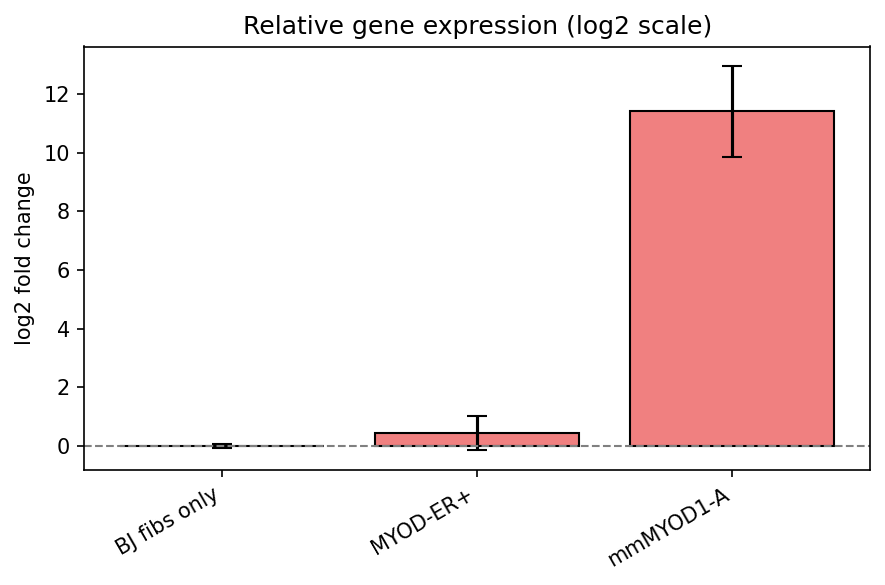

condition   mean_dCt    sd_dCt  n_bio       ddCt   se_ddCt   dd_lower  \
0  BJ fibs only  12.369889  0.021345      3   0.000000  0.017428  -0.074986   
1      MYOD-ER+  11.934000  0.238900      3  -0.435889  0.138478  -1.031712   
2     mmMYOD1-A   0.955556  0.626867      3 -11.414333  0.362132 -12.972461   

   dd_upper  fold_change    fc_lower     fc_upper     log2fc  log2fc_lower  \
0  0.074986     1.000000    0.949351     1.053351  -0.000000     -0.074986   
1  0.159934     1.352744    0.895066     2.044449   0.435889     -0.159934   
2 -9.856206  2729.334179  926.858816  8037.108711  11.414333      9.856206   

   log2fc_upper  err_lower_log2  err_upper_log2  
0      0.074986        0.074986        0.074986  
1      1.031712        0.595823        0.595823  
2     12.972461        1.558128        1.558128

In [6]:
# calibrator = "BJ fibs only"

# mdf1 = collapse_technical_replicates(mdf)
# mdf1 = compute_dCt(mdf1)
# summary = summarize_by_condition(mdf1)
# result = compute_ddCt_stats(summary, calibrator)

# barplot_log2fc(result)

# result.head()

In [11]:
mdf1 = collapse_technical_replicates(mdf)
mdf1 = compute_dCt(mdf1)

# ddCt = dCt(treatment) - dct(control)
avg_dCt_control = mdf1[mdf1['condition'] == 'BJ fibs only']['dCt'].mean()
mdf1['ddCt'] = mdf1['dCt'] - avg_dCt_control

mdf1['log2fc'] = mdf1['ddCt'] * -1

SD = mdf1.groupby('condition')['log2fc'].std()
SEM = mdf1.groupby('condition')['log2fc'].sem()

mdf1['SD_log2fc'] = mdf1['condition'].map(SD)
mdf1['SEM'] = mdf1['condition'].map(SEM)

mdf1

condition sample_id  bio_replicate  target_gene_ct_mean  \
0  BJ fibs only        #7              1            31.121667   
1  BJ fibs only        #8              2            30.499000   
2  BJ fibs only        #9              3            30.486000   
3      MYOD-ER+        #4              1            30.193333   
4      MYOD-ER+        #5              2            30.371333   
5      MYOD-ER+        #6              3            29.954333   
6     mmMYOD1-A       #13              1            19.389000   
7     mmMYOD1-A       #14              2            19.421000   
8     mmMYOD1-A       #15              3            20.510000   

   target_gene_ct_sd  GAPDH_ct_mean  GAPDH_ct_sd  tech_n        dCt  \
0           0.371126      18.737667     0.262734       3  12.384000   
1           0.131183      18.153667     0.104213       3  12.345333   
2           0.120835      18.105667     0.115941       3  12.380333   
3           0.029704      18.298333     0.074232       3  11.895000   
4           0.420207      18.181333     0.030534       3  12.190000   
5           0.163295      18.237333     0.036226       3  11.717000   
6           0.048570      18.841667     0.040204       3   0.547333   
7           0.045902      18.779000     0.150722       3   0.642000   
8           0.006245      18.832667     0.092381       3   1.677333   

        ddCt     log2fc  SD_log2fc       SEM  
0   0.014111  -0.014111   0.021345  0.012323  
1  -0.024556   0.024556   0.021345  0.012323  
2   0.010444  -0.010444   0.021345  0.012323  
3  -0.474889   0.474889   0.238900  0.137929  
4  -0.179889   0.179889   0.238900  0.137929  
5  -0.652889   0.652889   0.238900  0.137929  
6 -11.822556  11.822556   0.626867  0.361922  
7 -11.727889  11.727889   0.626867  0.361922  
8 -10.692556  10.692556   0.626867  0.361922

In [59]:
plot_df = mdf1.groupby('condition')['log2fc'].agg(['mean', 'sem']).reset_index()
plot_df.rename(columns={'mean': 'log2fc_mean', 'sem': 'SEM'}, inplace=True)

plot_df

condition   log2fc_mean       SEM
0  BJ fibs only -5.921189e-16  0.012323
1      MYOD-ER+  4.358889e-01  0.137929
2     mmMYOD1-A  1.141433e+01  0.361922

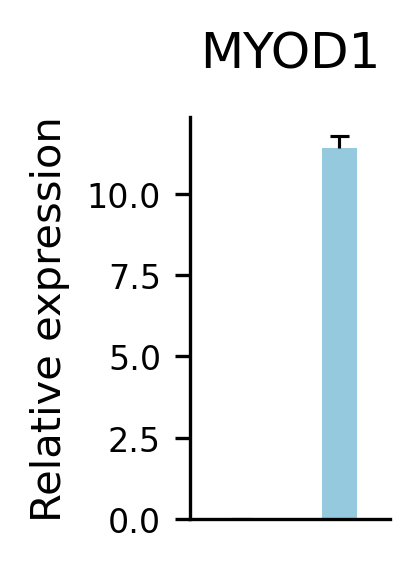

In [62]:
tmp = plot_df[plot_df['condition'] != 'MYOD-ER+'].reset_index(drop=True)
# tmp = plot_df.copy()

fig, ax = plt.subplots(figsize=(1.5,2), dpi=300) # with labels, 1.75, 2.75

sns.barplot(
    data=tmp,
    x='condition',
    y='log2fc_mean',
    color='skyblue',
    errorbar=None,
    ax=ax,
    width=0.35,
)

x_pos = np.arange(len(tmp))
for i in range(len(tmp)):
    mean = tmp.loc[i, 'log2fc_mean']
    sem = tmp.loc[i, 'SEM']
    ax.vlines(x_pos[i], mean, mean + sem, color='black', lw=0.75) # Draw only the top error bar
    ax.hlines(mean + sem, x_pos[i] - 0.1, x_pos[i] + 0.1, color='black', lw=0.75)  # top cap

    
    
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # aim for ~5 ticks
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.1f}"))

ax.margins(x=0.25)
ax.set_xticks(x_pos)
ax.tick_params(axis='x', bottom=False)#, labelbottom=False)
plt.yticks(fontsize=8)

tick_labels=['', '']
# tick_labels = ['Control', 'MYOD+']
# # tick_labels = ['Control', 'MYOD-C', 'MYOD+']

ax.set_xticklabels(tick_labels)
plt.xticks(rotation=90)  

plt.xlabel("")
plt.ylabel("Relative expression")
plt.title('MYOD1', pad=12)

sns.despine()
plt.tight_layout()
plt.show()

In [31]:
groups = mdf1.groupby("condition")["dCt"].apply(list)

normality_check(groups)
variance_check(groups)

two_group = {k: v for k, v in groups.items() if k in ["BJ fibs only", "mmMYOD1-A"]}

compare_two_groups(two_group)


Normality checks (Shapiro–Wilk test):
BJ fibs only: W=0.820, p=0.1642
MYOD-ER+: W=0.980, p=0.7291
mmMYOD1-A: W=0.812, p=0.1443

Levene’s test for equal variance: W=0.862, p=0.4686

Comparison: BJ fibs only vs mmMYOD1-A
Test used: Student’s t-test
Test statistic: 31.520
P-value: 6.038e-06
Normality p-values: BJ fibs only = 0.1642, mmMYOD1-A = 0.1443
Variance equality p-value (Levene’s test): 0.333
→ Result is statistically significant (p < 0.05)


In [32]:
two_group = {k: v for k, v in groups.items() if k in ["mmMYOD1-A", "MYOD-ER+"]}

compare_two_groups(two_group)


Comparison: MYOD-ER+ vs mmMYOD1-A
Test used: Student’s t-test
Test statistic: 28.345
P-value: 9.218e-06
Normality p-values: MYOD-ER+ = 0.7291, mmMYOD1-A = 0.1443
Variance equality p-value (Levene’s test): 0.5561
→ Result is statistically significant (p < 0.05)


In [33]:
two_group = {k: v for k, v in groups.items() if k in ["BJ fibs only", "MYOD-ER+"]}

compare_two_groups(two_group)


Comparison: BJ fibs only vs MYOD-ER+
Test used: Student’s t-test
Test statistic: 3.148
P-value: 0.03459
Normality p-values: BJ fibs only = 0.1642, MYOD-ER+ = 0.7291
Variance equality p-value (Levene’s test): 0.1694
→ Result is statistically significant (p < 0.05)


## PRRX1

In [14]:
gene = 'PRRX1'
conditions = ['BJ fibs only', 'siPRRX1-A']

pdf = subset_qpcr_data(df, gene, conditions)
print(pdf.shape)
pdf.head()

(18, 6)


condition sample_id  bio_replicate  tech_replicate  target_gene_ct  \
0  BJ fibs only        #7              1               1          17.834   
1  BJ fibs only        #7              1               2          17.880   
2  BJ fibs only        #7              1               3          17.849   
3  BJ fibs only        #8              2               1          17.947   
4  BJ fibs only        #8              2               2          17.985   

    GAPDH  
0  18.907  
1  18.871  
2  18.435  
3  18.274  
4  18.093

In [15]:
pdf1 = collapse_technical_replicates(pdf)
pdf1 = compute_dCt(pdf1)

# ddCt = dCt(treatment) - dct(control)
avg_dCt_control = pdf1[pdf1['condition'] == 'BJ fibs only']['dCt'].mean()
pdf1['ddCt'] = pdf1['dCt'] - avg_dCt_control

pdf1['log2fc'] = pdf1['ddCt'] * -1

SD = pdf1.groupby('condition')['log2fc'].std()
SEM = pdf1.groupby('condition')['log2fc'].sem()

pdf1['SD_log2fc'] = pdf1['condition'].map(SD)
pdf1['SEM'] = pdf1['condition'].map(SEM)

pdf1

condition sample_id  bio_replicate  target_gene_ct_mean  \
0  BJ fibs only        #7              1            17.854333   
1  BJ fibs only        #8              2            18.046000   
2  BJ fibs only        #9              3            17.932667   
3     siPRRX1-A       #10              1            19.616000   
4     siPRRX1-A       #11              2            19.376000   
5     siPRRX1-A       #12              3            19.921000   

   target_gene_ct_sd  GAPDH_ct_mean  GAPDH_ct_sd  tech_n       dCt      ddCt  \
0           0.023459      18.737667     0.262734       3 -0.883333 -0.495333   
1           0.139861      18.153667     0.104213       3 -0.107667  0.280333   
2           0.053715      18.105667     0.115941       3 -0.173000  0.215000   
3           0.099745      18.692667     0.192147       3  0.923333  1.311333   
4           0.101926      18.635000     0.050110       3  0.741000  1.129000   
5           0.015875      18.840333     0.055537       3  1.080667  1.468667   

     log2fc  SD_log2fc       SEM  
0  0.495333   0.430213  0.248384  
1 -0.280333   0.430213  0.248384  
2 -0.215000   0.430213  0.248384  
3 -1.311333   0.169987  0.098142  
4 -1.129000   0.169987  0.098142  
5 -1.468667   0.169987  0.098142

In [53]:
plot_df = pdf1.groupby('condition')['log2fc'].agg(['mean', 'sem']).reset_index()
plot_df.rename(columns={'mean': 'log2fc_mean', 'sem': 'SEM'}, inplace=True)

plot_df

condition   log2fc_mean       SEM
0  BJ fibs only -1.850372e-17  0.248384
1     siPRRX1-A -1.303000e+00  0.098142

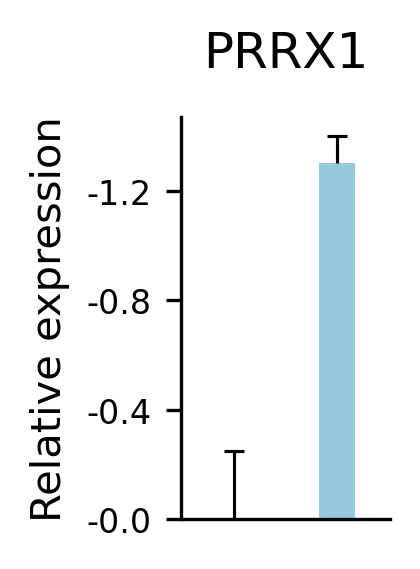

In [58]:
tmp = plot_df.copy()
tmp['plot_mean'] = tmp['log2fc_mean'].abs()

fig, ax = plt.subplots(figsize=(1.5,2), dpi=300)

sns.barplot(
    data=tmp,
    x='condition',
    y='plot_mean',
    color='skyblue',
    errorbar=None,
    ax=ax,
    width=0.35,
)

x_pos = np.arange(len(tmp))
for i in range(len(tmp)):
    mean = tmp.loc[i, 'plot_mean']
    sem = tmp.loc[i, 'SEM']
    ax.vlines(x_pos[i], mean, mean + sem, color='black', lw=0.75) # Draw only the top error bar
    ax.hlines(mean + sem, x_pos[i] - 0.1, x_pos[i] + 0.1, color='black', lw=0.75)  # top cap

ax.yaxis.set_major_locator(MaxNLocator(nbins=4))  # aim for ~5 ticks
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{-y:.1f}"))
    
ax.margins(x=0.25)
ax.tick_params(axis='x', bottom=False)#, pad=5)
plt.yticks(fontsize=8)

# tick_labels = ['Control', r'PRRX1$^{\mathrm{KD}}$']
tick_labels=['', '']

ax.set_xticks(x_pos)
ax.set_xticklabels(tick_labels)

plt.xticks(rotation=90)   
plt.xlabel("")
plt.ylabel("Relative expression")
plt.title('PRRX1', pad=12)

sns.despine()
plt.tight_layout()
plt.show()

In [30]:
groups = pdf1.groupby("condition")["dCt"].apply(list)

normality_check(groups)
variance_check(groups)

two_group = {k: v for k, v in groups.items() if k in ["BJ fibs only", "siPRRX1-A"]}

compare_two_groups(two_group)


Normality checks (Shapiro–Wilk test):
BJ fibs only: W=0.813, p=0.1452
siPRRX1-A: W=0.998, p=0.9189

Levene’s test for equal variance: W=0.387, p=0.5678

Comparison: BJ fibs only vs siPRRX1-A
Test used: Student’s t-test
Test statistic: -4.879
P-value: 0.008167
Normality p-values: BJ fibs only = 0.1452, siPRRX1-A = 0.9189
Variance equality p-value (Levene’s test): 0.5678
→ Result is statistically significant (p < 0.05)


#

In [5]:
summary = (
    mean_tech
    .groupby('condition')
    .agg(mean_dCt=('dCt','mean'),
         sd_dCt=('dCt','std'),
         n_bio=('dCt','count'))
    .reset_index()
)

print(summary.shape)
summary.head()

(3, 4)


condition   mean_dCt    sd_dCt  n_bio
0  BJ fibs only  12.369889  0.021345      3
1      MYOD-ER+  11.934000  0.238900      3
2     mmMYOD1-A   0.955556  0.626867      3

In [6]:
calibrator = 'BJ fibs only'   # pick the calibrator you want
cal_row = summary[summary['condition'] == calibrator].iloc[0]
mean_cal = cal_row['mean_dCt']
sd_cal = cal_row['sd_dCt']
n_cal = int(cal_row['n_bio'])


def compute_dd_stats(row, mean_cal=mean_cal, sd_cal=sd_cal, n_cal=n_cal):
    m = row['mean_dCt']
    sd = row['sd_dCt']
    n = int(row['n_bio'])
    dd = m - mean_cal
    # SE of ddCt
    se_dd = np.sqrt((sd**2)/n + (sd_cal**2)/n_cal)
    # t multiplier for 95% CI
    df_approx = min(n-1, n_cal-1)
    tval = t.ppf(0.975, df_approx) if df_approx > 0 else 1.96
    lower_dd = dd - tval * se_dd
    upper_dd = dd + tval * se_dd

    # fold change (linear space)
    fc = 2**(-dd)
    fc_lower = 2**(-upper_dd)
    fc_upper = 2**(-lower_dd)

    # log2 fold change = -ddCt
    if dd == 0:
        log2fc = dd
    else:
        log2fc = -dd
    log2fc_lower = -upper_dd   # reversed bounds
    log2fc_upper = -lower_dd

    return pd.Series(dict(
        ddCt=dd,
        se_ddCt=se_dd,
        dd_lower=lower_dd,
        dd_upper=upper_dd,
        fold_change=fc,
        fc_lower=fc_lower,
        fc_upper=fc_upper,
        log2fc=log2fc,
        log2fc_lower=log2fc_lower,
        log2fc_upper=log2fc_upper
    ))

dd_stats = summary.apply(compute_dd_stats, axis=1)
result = pd.concat([summary, dd_stats], axis=1)
result

condition   mean_dCt    sd_dCt  n_bio       ddCt   se_ddCt   dd_lower  \
0  BJ fibs only  12.369889  0.021345      3   0.000000  0.017428  -0.074986   
1      MYOD-ER+  11.934000  0.238900      3  -0.435889  0.138478  -1.031712   
2     mmMYOD1-A   0.955556  0.626867      3 -11.414333  0.362132 -12.972461   

   dd_upper  fold_change    fc_lower     fc_upper     log2fc  log2fc_lower  \
0  0.074986     1.000000    0.949351     1.053351   0.000000     -0.074986   
1  0.159934     1.352744    0.895066     2.044449   0.435889     -0.159934   
2 -9.856206  2729.334179  926.858816  8037.108711  11.414333      9.856206   

   log2fc_upper  
0      0.074986  
1      1.031712  
2     12.972461

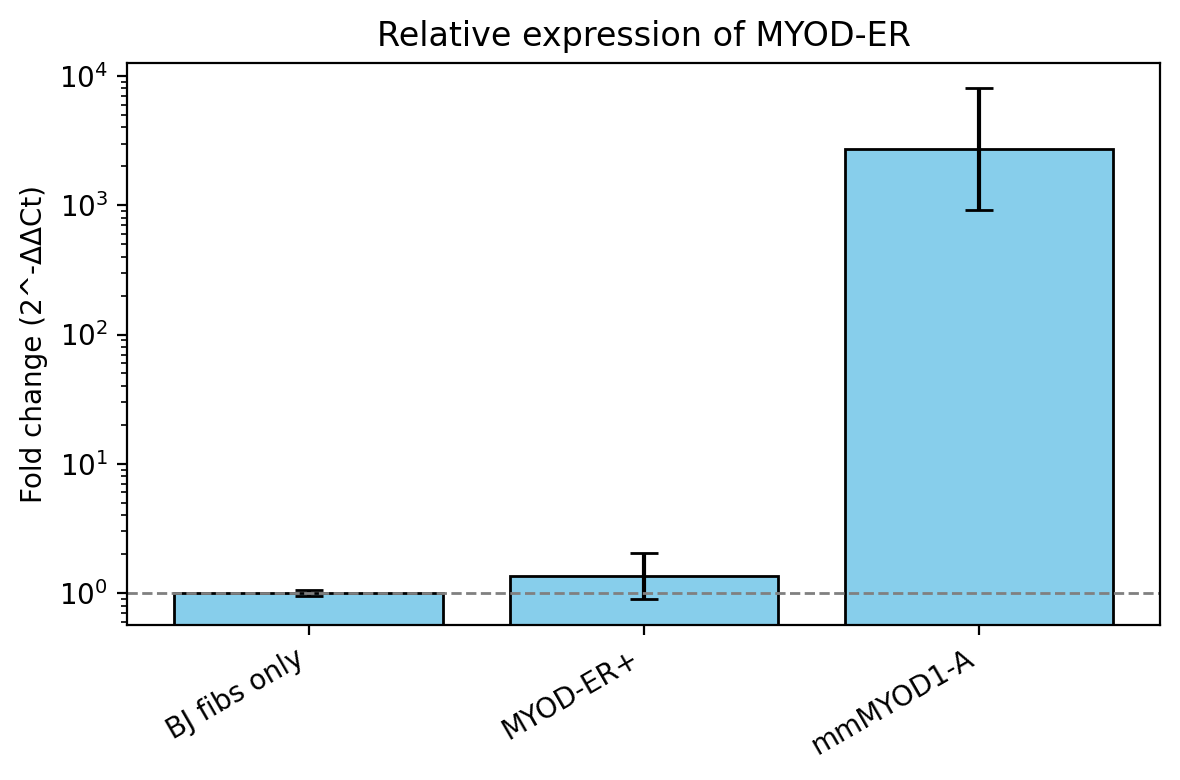

In [36]:
result['err_lower'] = result['fold_change'] - result['fc_lower']
result['err_upper'] = result['fc_upper'] - result['fold_change']


fig, ax = plt.subplots(figsize=(6,4), dpi=200)

ax.bar(result['condition'], result['fold_change'], 
       yerr=[result['err_lower'], result['err_upper']],
       capsize=5, color='skyblue', edgecolor='black')

ax.set_ylabel("Fold change (2^-ΔΔCt)")
ax.set_title("Relative expression of MYOD-ER")
ax.axhline(1, color='gray', linestyle='--', linewidth=1)  # reference line at 1

plt.xticks(rotation=30, ha='right')

plt.yscale('log')

plt.tight_layout()
plt.show()

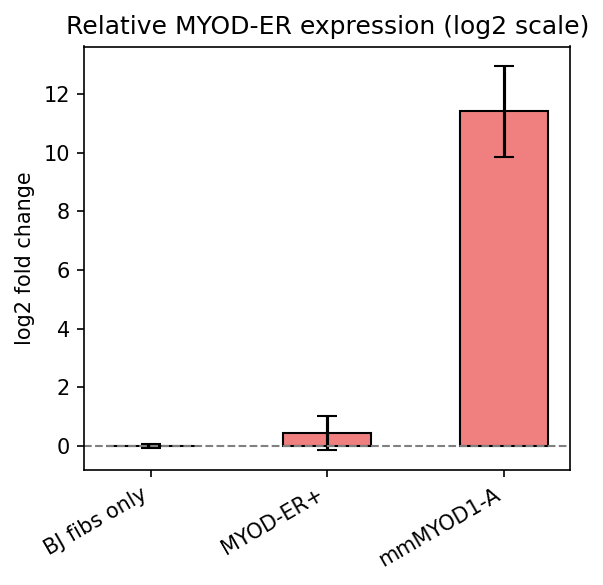

In [9]:
result['err_lower_log2'] = result['log2fc'] - result['log2fc_lower']
result['err_upper_log2'] = result['log2fc_upper'] - result['log2fc']

fig, ax = plt.subplots(figsize=(4,4), dpi=150)

ax.bar(result['condition'], result['log2fc'],
       yerr=[result['err_lower_log2'], result['err_upper_log2']],
       capsize=5, color='lightcoral', edgecolor='black', width=0.5)

ax.axhline(0, color='gray', linestyle='--', linewidth=1)  # reference line at 0
ax.set_ylabel("log2 fold change")
ax.set_title("Relative MYOD-ER expression (log2 scale)")

plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


In [10]:
import scipy.stats as stats
import itertools

In [11]:
groups = mean_tech.groupby("condition")["dCt"].apply(list)

# --- 1) One-way ANOVA ---
f_stat, p_anova = stats.f_oneway(*groups)
print("One-way ANOVA on ΔCt values:")
print(f"F = {f_stat:.3f}, p = {p_anova:.4f}")


# --- 2) Pairwise Welch’s t-tests (unequal variance) ---
pairs = list(itertools.combinations(groups.index, 2))
pairwise_results = []

for g1, g2 in pairs:
    t_stat, p_val = stats.ttest_ind(groups[g1], groups[g2], equal_var=False)
    pairwise_results.append({"group1": g1, "group2": g2, "t": t_stat, "p": p_val})

pairwise_df = pd.DataFrame(pairwise_results)
print("\nPairwise comparisons (Welch’s t-test):")
print(pairwise_df)

One-way ANOVA on ΔCt values:
F = 835.765, p = 0.0000

Pairwise comparisons (Welch’s t-test):
         group1     group2          t         p
0  BJ fibs only   MYOD-ER+   3.147709  0.086074
1  BJ fibs only  mmMYOD1-A  31.519828  0.000992
2      MYOD-ER+  mmMYOD1-A  28.345094  0.000281


In [14]:
pairs = list(itertools.combinations(groups.index, 2))
pairwise_results = []

for g1, g2 in pairs:
    t_stat, p_val = stats.ttest_ind(groups[g1], groups[g2], equal_var=False)
    pairwise_results.append({"group1": g1, "group2": g2, "t": t_stat, "p_uncorrected": p_val})

pairwise_df = pd.DataFrame(pairwise_results)

# Bonferroni correction
pairwise_df["p_bonferroni"] = pairwise_df["p_uncorrected"] * len(pairwise_df)
pairwise_df["p_bonferroni"] = pairwise_df["p_bonferroni"].clip(upper=1.0)  # cap at 1

print("\nPairwise Welch’s t-tests with Bonferroni correction:")
print(pairwise_df)


Pairwise Welch’s t-tests with Bonferroni correction:
         group1     group2          t  p_uncorrected  p_bonferroni
0  BJ fibs only   MYOD-ER+   3.147709       0.086074      0.258223
1  BJ fibs only  mmMYOD1-A  31.519828       0.000992      0.002976
2      MYOD-ER+  mmMYOD1-A  28.345094       0.000281      0.000844


In [12]:
for cond, values in groups.items():
    stat, p = stats.shapiro(values)
    print(f"{cond}: W={stat:.3f}, p={p:.4f}")

BJ fibs only: W=0.820, p=0.1642
MYOD-ER+: W=0.980, p=0.7291
mmMYOD1-A: W=0.812, p=0.1443


In [13]:
# --- 1) Kruskal–Wallis across all groups ---
h_stat, p_kw = stats.kruskal(*groups)
print("Kruskal–Wallis test on ΔCt values:")
print(f"H = {h_stat:.3f}, p = {p_kw:.4f}")

# --- 2) Pairwise comparisons (Mann–Whitney U test) ---
pairs = list(itertools.combinations(groups.index, 2))
pairwise_results = []

for g1, g2 in pairs:
    u_stat, p_val = stats.mannwhitneyu(groups[g1], groups[g2], alternative="two-sided")
    pairwise_results.append({"group1": g1, "group2": g2, "U": u_stat, "p": p_val})

pairwise_df = pd.DataFrame(pairwise_results)
print("\nPairwise comparisons (Mann–Whitney U test):")
print(pairwise_df)

Kruskal–Wallis test on ΔCt values:
H = 7.200, p = 0.0273

Pairwise comparisons (Mann–Whitney U test):
         group1     group2    U    p
0  BJ fibs only   MYOD-ER+  9.0  0.1
1  BJ fibs only  mmMYOD1-A  9.0  0.1
2      MYOD-ER+  mmMYOD1-A  9.0  0.1


In [15]:
pairwise_results_mw = []

for g1, g2 in pairs:
    u_stat, p_val = stats.mannwhitneyu(groups[g1], groups[g2], alternative="two-sided")
    pairwise_results_mw.append({"group1": g1, "group2": g2, "U": u_stat, "p_uncorrected": p_val})

pairwise_df_mw = pd.DataFrame(pairwise_results_mw)

# Bonferroni correction
pairwise_df_mw["p_bonferroni"] = pairwise_df_mw["p_uncorrected"] * len(pairwise_df_mw)
pairwise_df_mw["p_bonferroni"] = pairwise_df_mw["p_bonferroni"].clip(upper=1.0)

print("\nPairwise Mann–Whitney U tests with Bonferroni correction:")
print(pairwise_df_mw)


Pairwise Mann–Whitney U tests with Bonferroni correction:
         group1     group2    U  p_uncorrected  p_bonferroni
0  BJ fibs only   MYOD-ER+  9.0            0.1           0.3
1  BJ fibs only  mmMYOD1-A  9.0            0.1           0.3
2      MYOD-ER+  mmMYOD1-A  9.0            0.1           0.3


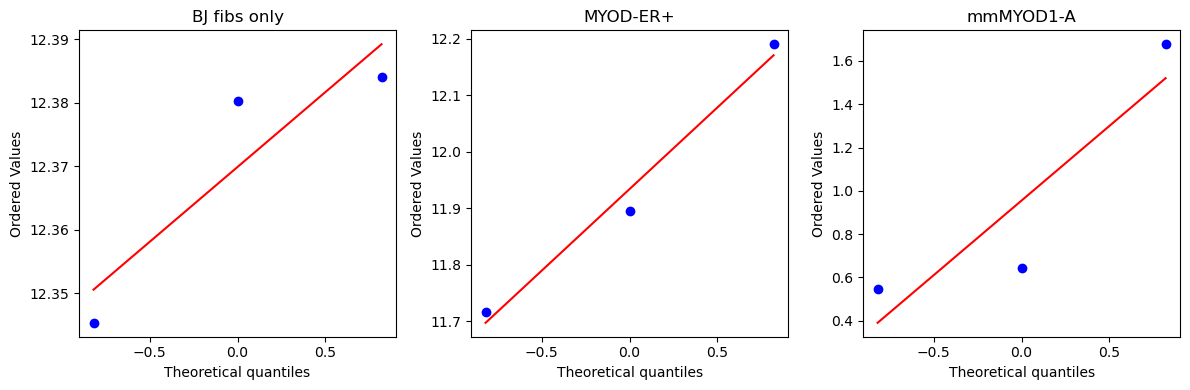

In [17]:
fig, axes = plt.subplots(1, len(groups), figsize=(12, 4))

for ax, (cond, values) in zip(axes, groups.items()):
    stats.probplot(values, dist="norm", plot=ax)
    ax.set_title(cond)

plt.tight_layout()
plt.show()